<p> Segunda Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Vilca

Marzo, 2022

# 2. Balance de Energía Superficial - Modelo METRIC

> Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)
- METRIC is an image-processing model for calculating ET as a residual of the surface energy balance. 
- METRIC was developed by the University of Idaho for application to Landsat satellite imagery to maximize ET product resolution (30 m).
- METRIC uses as its foundation the pioneering SEBAL energy balance process developed in the Netherlands by Bastiaanssen et al. . 

## Inicio

Ejecutar todas las celdas ubicadas en esta sección para su uso posterior:
- Ingreso de creedenciales para usar Earth Engine en Colab (importa `ee` y login)
- Importar librerías como `geemap`, `pandas`, `matplotlib` entre otras.
- Ejecutar funciones realizadas para agilizar procesos repetitivos en ciertas ocasiones.

#### Ingreso de creedenciales para uso de Earth Engine

[geemap](https://geemap.org/) es un paquete de Python para obtener visualizaciones interactivas con Google Earth Engine (GEE).

In [5]:
import os
os.getcwd()

'C:\\Users\\usuario\\Documents\\00-notebooks-2022'

In [2]:
import ee
ee.Initialize()

import math
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.dates as mpl_dates # Modificar fechas por formato
# date_format = mpl_dates.DateFormatter('%Y-%m')

import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes (cm se confunde con matplotlib)

# Importar 
%pylab inline 
from geemap import cartoee

Populating the interactive namespace from numpy and matplotlib


#### Funciones

Es necesario desarrollar funciones para ciertos componentes reutilizables:
- Modelo digital de elevación DEM
- Mapa de pendientes (grados)
- Mapa del Coseno del ángulo solar de incidencia Cosθ
- Mapa de transmitancias τ
- Mapa de albedo α
- Mapa de NDVI
- Mapa de LAI
- Mapa de Temperatura superficial en Kelvin
- Mapa de emisividad ε
- Mapa de Temperatura superficial corregido a partir de mapa de elevación `ts_dem`

Para poder estimar:
- R_n
- G
- H

In [6]:
from funciones import *

In [5]:
# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

##### Elaboración de gráficas y tablas

In [7]:
# @markdown Función `get_stats(img, geometry, scale)`

# @markdown Los reductores son `.unweighted()` 

def get_stats(img, geometry, scale):

  ''' Obtener valores estadísticos de la imagen
  Uso de ee.Image.reduceRegion para obtener estadísticas
  Inputs: 
    ee.Image, ee.Geometry, scale (valor de pixel)
  Retorna: 
    Media, Mediana, Moda, Desviación estándar, Mínimo y Máximo
    (unweighted)
  '''
  
  mean   = img.reduceRegion(ee.Reducer.mean().unweighted()  , geometry=geometry, scale=scale)
  median = img.reduceRegion(ee.Reducer.median().unweighted(), geometry=geometry, scale=scale)
  mode   = img.reduceRegion(ee.Reducer.mode().unweighted()  , geometry=geometry, scale=scale)
  stdDev = img.reduceRegion(ee.Reducer.stdDev(), geometry=geometry, scale=scale)
  min_   = img.reduceRegion(ee.Reducer.min(), geometry=geometry, scale=scale)
  max_   = img.reduceRegion(ee.Reducer.max(), geometry=geometry, scale=scale)

  values = ee.List([mean, median, mode, stdDev, min_, max_])
  columns = ['mean','median','mode','stdDev','min','max']
                    
  stats = ee.Dictionary.fromLists(columns, values).getInfo()
  # stats_df = pd.DataFrame.from_dict(stats, orient='index')
  return stats

In [8]:
# @markdown Función `get_grafica_cartoee(image, vis_params, title_map, label, img_date, save_fig=None)`

def get_grafica_cartoee(
    image, vis_params, title_map, label, img_date, save_fig=None):

  zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

  fig = plt.figure(figsize=(8,6))

  # ee.Image a plotear
  ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

  # Añadir barra de color
  cb = cartoee.add_colorbar(ax, vis_params=vis_params, loc='right', label=label)

  # Añadir grillas
  cartoee.add_gridlines(ax, interval=0.005, ytick_rotation=90, linestyle=":") # xtick_rotation=45

  # Añadir texto
  ax.text(-79.78275, -6.5955, f'{title_map}\n{img_date}', fontsize=14)

  # add scale bar
  scale_bar_dict = {
      "length": 100, 
      "xy": (0.9, 0.05), 
      "linewidth": 3,
      "fontsize": 12,
      "color": "black",
      "unit": "m",
      "ha": "center",
      "va": "bottom"    
  }
  cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

  # Guardar graficas
  if save_fig == True:
    # plt.savefig(f'/Users/usuario/Downloads/{title_map}_{img_date}.jpg')
    # plt.savefig(f'/content/{title_map}_{img_date}.jpg')
    ruta = r'C:/Users/usuario/Documents/00-notebooks-2022/'
    ruta_img = ruta + title_map + '_' + img_date + '.jpg'
    plt.savefig(ruta_img)
  else:
    pass

  plt.show()

`reduceRegion`
- Caso: Contar pixeles totalmente dentro de una region: https://gis.stackexchange.com/questions/356760/earthengine-count-number-of-fully-covered-pixels-within-a-region
- Que sucede cuando hay más pixeles de los que puede analizar earth engine: https://developers.google.com/earth-engine/tutorials/tutorial_forest_03#quantifying-forest-change-in-a-region-of-interest
- Primero rasteriza la region para luego estimar el reductor:
  > Earth Engine determines which pixels to input to the reducer by first rasterizing the region. If a scale is specified without a CRS, the region is rasterized in the image's native projection scaled to the specified resolution. If both a CRS and scale are specified, the region is rasterized based on them.

## Assets 

In [9]:
# Assets
asset_dept = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_prov = ee.FeatureCollection('users/CesarVilca/provincias')
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
deptSelectedName = 'LAMBAYEQUE'
provSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHICLAYO'
distSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHONGOYAPE'

dept_fcol = asset_dept.filterMetadata('DEPARTAMEN', 'equals', deptSelectedName)
prov_fcol = asset_prov.filterMetadata('PROVINCIA', 'equals', provSelectedName)
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', distSelectedName)

# ROI Caja
roi = dist_fcol.geometry().bounds()

empty = ee.Image().paint(dist_fcol, 2,2)
empty2 = ee.Image().paint(roi, 2, 2)

# Visualización
# Map = geemap.Map(layer_ctrl = True) 
# Map.centerObject(dist_fcol, 9)

# Map.addLayer(dept_fcol, {'color':'red'}, f'Departamento {deptSelectedName}')
# Map.addLayer(prov_fcol, {'color':'green'}, f'Provincia {provSelectedName} ')
# Map.addLayer(dist_fcol, {'color':'blue'}, f'Distrito {distSelectedName}')

# # Bordes
# Map.addLayer(empty , {}, 'Distrito Seleccionado')
# Map.addLayer(empty2, {}, 'Limites')

# Map

##### Área de evaluación: Ferreñafe - Áreas voladas

El área de estudio en formato shapefile se encuentra alojado en un repositorio en Github, se procederá a descargarlo e importarlo como `ee.FeatureCollection` con `geemap`.

In [10]:
ruta_ferrenafe = r'files/Ferreñafe_areas.shp' # en Local
# ruta_ferrenafe = r'/content/Ferreñafe_areas.shp' # en Colab

predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 1, 1) # Para visualización con geemap

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1) # Para visualización con geemap

type(predios_agricolas)

ee.featurecollection.FeatureCollection

## Balance de Energía Superficial

En esta sección se desarrollará los 3 componentes de la ecuación de balance de energía superficial:
- Radiación Neta $R_n$
- Flujo de calor del suelo $G$
- Flujo de calor sensible del aire $H$

Tendremos como valores input imágenes satelitales Landsat 8 y 9, así como datos meteorológicos.



Reporte con imágenes Landsat 8 y 9 unidos con sus respectivos datos de Evapotranspiración horaria y velocidad de viento de la estación meteorológica INIA Vista Florida.

### Radiación Neta $R_n$

The net radiation flux at the surface ($R_n$) represents the actual radiant energy available at the surface.

$$
R_n = R_{S\downarrow} - \alpha R_{S\downarrow} + R_{L\downarrow} - R_{L\uparrow} - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
R_n = (1- \alpha)R_{S\downarrow} + (R_{L\downarrow} - R_{L\uparrow}) - (1- \varepsilon_0)R_{L\downarrow}
$$

$$
\text{Net surface radiation} = \text{gains} - \text{losses}
$$

Dónde: 
- $R_n \;$ : Flujo de radiación neta $[W/m^2]$
- $\alpha \;\;\;\;$ : Albedo de superficie $[-]$
- $R_{S\downarrow}$ : Radiación de onda corta entrante $[W/m^2]$
- $R_{L\downarrow}$ : Radiación de onda larga entrante $[W/m^2]$
- $R_{L\uparrow}$ : Radiación de onda larga saliente $[W/m^2]$
- $\epsilon_0 \;\;\;$ : Emisividad del ancho de banda en la superficie / broad-band surface thermal emissivity

El término $(1- \epsilon_0)R_{L\downarrow}$ representa la fracción de radiación entrante de onda larga (incoming long-wave radiation) reflejada desde la superficie.

Se ha seleccionado las siguientes imágenes:

| Index | ID |
|-|-|
|1 | `LANDSAT/LC09/C02/T1/LC09_010065_20211212`|
|5 | `LANDSAT/LC09/C02/T1/LC09_010065_20220113`|
|7 | `LANDSAT/LC09/C02/T1/LC09_010065_20220129`|
|9 | `LANDSAT/LC08/C02/T1/LC08_010065_20220310`|
|X | `LANDSAT/LC09/C02/T1/LC09_010065_20220403`|

In [11]:
# Imágenes seleccionadas
ids = [
       'LANDSAT/LC09/C02/T1/LC09_010065_20211212', #12 12
       'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # OJO: NDVI negativos -> Posible riego 01 13
       'LANDSAT/LC09/C02/T1/LC09_010065_20220129', #01 29
       'LANDSAT/LC08/C02/T1/LC08_010065_20220310', #03 10
       'LANDSAT/LC09/C02/T1/LC09_010065_20220403'  #04 03
      ]

In [12]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

# Imagen Landsat
img_id = ids[0]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
img_Ts_K = img_productos.select('Ts_k')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

print(f'Rn de imagen {img_date} procesada!')

ValueError: too many values to unpack (expected 5)

In [22]:
R_n_stats = get_stats(R_n, predios_agricolas, 10)
R_n_stats_df = pd.DataFrame.from_dict(R_n_stats, orient='index').round(2)
R_n_stats_df # [W/m^2]

,R_l_in,R_l_out,R_n,R_s_in
max,357.33,434.10,717.79,868.55
mean,337.26,410.26,610.02,822.47
median,337.87,410.87,605.53,822.35
min,315.91,387.52,517.22,786.20
mode,339.12,412.13,587.50,822.35
stdDev,7.82,9.02,36.73,11.82


In [23]:
img_prod_stats = get_stats(img_productos, predios_agricolas, 30)
img_prod_stats_df = pd.DataFrame.from_dict(img_prod_stats, orient='index')#.round(3)
img_prod_stats_df

,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,t_sw
max,0.554053,0.467943,0.333643,26.499555,299.649555,0.249194,0.913931,0.985000,0.985000,0.674302
mean,-0.033401,0.135477,0.080136,22.175984,295.325984,0.149351,0.865485,0.950935,0.970427,0.674191
median,-0.041103,0.134750,0.077141,22.345280,295.465761,0.155909,0.865423,0.949587,0.969877,0.674188
min,-0.295880,-0.280061,-0.082300,17.408391,290.558391,0.024846,0.827308,0.948287,0.969435,0.674101
mode,-0.037025,0.134750,0.075142,22.595220,295.465761,0.170479,0.865423,0.949587,0.969877,0.674179
stdDev,0.082424,0.067761,0.043690,1.714535,1.714535,0.041136,0.012458,0.006456,0.002754,0.000039


###### Prueba: Elaboración de boxplot

Matplotlib - Boxplot:
- https://matplotlib.org/stable/gallery/index.html#statistics
- https://matplotlib.org/stable/gallery/statistics/boxplot.html#sphx-glr-gallery-statistics-boxplot-py

Ojo con los ee.Reducer:
- [Reducer / Statistics of an Image Region - Pixels in the region](https://developers.google.com/earth-engine/guides/reducers_reduce_region#pixels-in-the-region)
- [Reducer / Weighted Reductions](https://developers.google.com/earth-engine/guides/reducers_weighting): By default, reducers applied to imagery weight the inputs according to the mask value. This is relevant in the context of fractional pixels created through operations such as clip(). Adjust this behavior by calling unweighted() on the reducer. Using an unweighted reducer forces all pixels in the region to have the same weight. 
- [ee.Reducer.median](https://developers.google.com/earth-engine/apidocs/ee-reducer-median)
- [ee.Reducer.mean](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)

In [24]:
import numpy as np

In [26]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

lista_dates = []
lista_ndvi_boxplot = []
lista_savi_boxplot = []
lista_lai_boxplot = []
lista_albedo_boxplot = []

lista_boxplot = []

for id in ids:
    
  # Imagen Landsat
  img_id = id
  img_ee = ee.Image(img_id).clip(roi)
  img_toa = convert_RAW_to_TOA(img_ee)
  img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
  lista_dates.append(img_date)

  # Radiación Neta
  R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

  # Imágenes
  img_ndvi = img_productos.select('NDVI')
  img_savi = img_productos.select('SAVI')
  img_lai  = img_productos.select('LAI')
  img_albedo = img_productos.select('albedo')

  # Convertir ee.Image a numpy.array
  ndvi_list_values = img_ndvi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('NDVI').getInfo()
  savi_list_values = img_savi.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('SAVI').getInfo()
  lai_list_values  = img_lai.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('LAI').getInfo()
  albedo_list_values = img_albedo.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('albedo').getInfo()

  # ndvi_array = np.array(ndvi_list_values)
  # lista_prueba = ndvi_array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

  lista_ndvi_boxplot.append(ndvi_list_values)
  lista_savi_boxplot.append(savi_list_values)
  lista_lai_boxplot.append(lai_list_values)
  lista_albedo_boxplot.append(albedo_list_values)

  print(f'Rn de imagen {img_date} procesada!') 

Rn de imagen 2021-12-12 procesada!
Rn de imagen 2022-01-13 procesada!
Rn de imagen 2022-01-29 procesada!
Rn de imagen 2022-03-10 procesada!
Rn de imagen 2022-04-03 procesada!


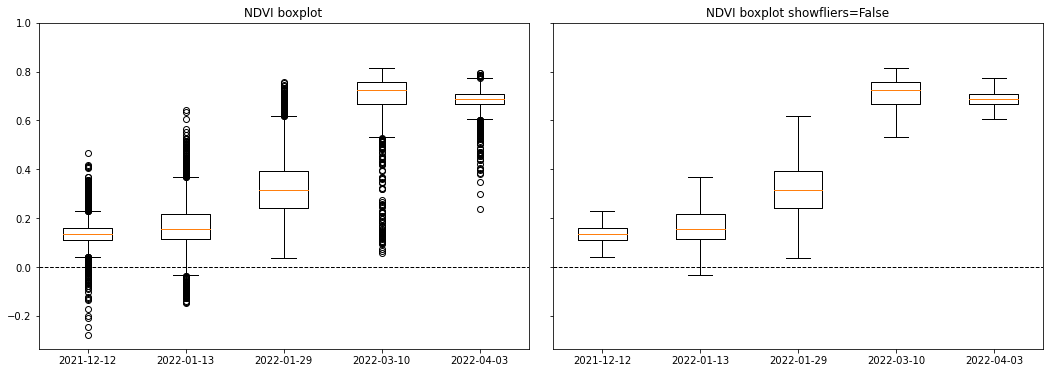

In [28]:
# Visualización de Boxplot con Matplotlib
title_boxplot = 'NDVI boxplot'
lista_boxplot = lista_ndvi_boxplot
# lista_boxplot = lista_savi_boxplot
# lista_boxplot = lista_lai_boxplot
# lista_boxplot = lista_albedo_boxplot

# Boxplot NDVI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

axs[0].boxplot(lista_boxplot,labels=lista_dates)
axs[0].set_title(title_boxplot)
axs[0].set_ylim(top=1)
axs[0].axhline(0, color='k', ls='--', lw=1)

axs[1].boxplot(lista_boxplot,
               labels=lista_dates,
               showfliers=False)
axs[1].set_title(f'{title_boxplot} showfliers=False')
axs[1].set_ylim(top=1)
axs[1].axhline(0, color='k', ls='--', lw=1)

fig.subplots_adjust(wspace=0.05)
plt.show()

In [ ]:
# Guardar un array como .txt
ruta = r'/Users/usuario/Documents/00-notebooks-2022/files/'

array_albedo = np.array(lista_albedo_boxplot)
array_nvdi = np.array(lista_ndvi_boxplot)
array_savi = np.array(lista_savi_boxplot)
array_lai  = np.array(lista_lai_boxplot)

# numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)[source]
np.savetxt(f'{ruta}array_albedo.txt', array_albedo)
np.savetxt(f'{ruta}array_nvdi.txt', array_nvdi)
np.savetxt(f'{ruta}array_savi.txt', array_savi)
np.savetxt(f'{ruta}array_lai.txt', array_lai)

In [ ]:
# Lectura de numpy.array en .txt para leer boxplot
np_albedo = np.loadtxt(f'{ruta}array_albedo.txt').tolist()

In [ ]:
# Boxplot
plt.figure(figsize=(9, 6))
plt.boxplot(np_albedo);

In [ ]:
def get_boxplot(lista, title):
  title_boxplot = title
  lista_boxplot = lista
  # Boxplot NDVI
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

  axs[0].boxplot(lista_boxplot,labels=lista_dates)
  axs[0].set_title(title_boxplot)
  # axs[0].set_ylim(top=1)
  axs[0].axhline(0, color='k', ls='--', lw=1)

  axs[1].boxplot(lista_boxplot,
                labels=lista_dates,
                showfliers=False)
  axs[1].set_title(f'{title_boxplot} showfliers=False')
  # axs[1].set_ylim(top=1)
  axs[1].axhline(0, color='k', ls='--', lw=1)

  fig.subplots_adjust(wspace=0.05)
  plt.show()

In [ ]:
get_boxplot(lista_ndvi_boxplot, 'Albedo boxplot')

In [ ]:
get_boxplot(lista_savi_boxplot, 'SAVI boxplot')

In [ ]:
get_boxplot(lista_lai_boxplot, 'LAI boxplot')

In [ ]:
# Visualizando una solo boxplot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
ax1.boxplot(lista_boxplot[0],
            labels=[lista_dates[0]],
            showfliers=False)
ax1.set_ylim(0,1)
ax1.set_title('NDVI Boxplot');

In [ ]:
# Prueba de Matplotlib: Object-based method
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 6), sharey=True)
axs[0].boxplot(lista_boxplot[0],
                 labels=[lista_dates[0]])
axs[0].set_title('NDVI boxplot')
axs[0].set_ylim(0,1)

axs[1].boxplot(lista_boxplot[1],
                 labels=[lista_dates[1]])
axs[1].set_title('NDVI boxplot')
axs[1].set_ylim(0,1)

axs[2].boxplot(lista_boxplot[2],
                 labels=[lista_dates[2]])
axs[2].set_title('NDVI boxplot')
axs[2].set_ylim(0,1)

axs[3].boxplot(lista_boxplot[3],
                 labels=[lista_dates[3]])
axs[3].set_title('NDVI boxplot')
axs[3].set_ylim(0,1)

axs[4].boxplot(lista_boxplot[4],
                 labels=[lista_dates[4]])
axs[4].set_title('NDVI boxplot')
axs[4].set_ylim(0,1)

plt.show()

In [ ]:
# Primer camino para obtener pixeles de imagen dentro de una region rectangular
prueba = img_ndvi.sampleRectangle(region=predios_agricolas, defaultValue=0)
prueba.get('B5').getInfo()#.get('NDVI')

array = np.array(prueba.get('B5').getInfo())
# array

# plt.imshow(array)
# plt.show()

# Reducir a 1 dimension 
lista_prueba = array.flatten('C').tolist() # https://www.javatpoint.com/numpy-flatten

# Elaborar boxplot:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

plt.boxplot(lista_prueba);

#### Evaluando parámetros de Radiación Neta


##### Radiación Neta

In [ ]:
R_n_stats['R_n']

In [ ]:
# Visualización
vis_params_R_n = {'min': float(R_n_stats['R_n']['min']), 
                  'max': float(R_n_stats['R_n']['max']), 
                  'palette': cmp.get_palette('RdYlGn_r')}

image = R_n.select('R_n').clip(predios_agricolas)
vis_params = vis_params_R_n
title_map = 'R_n'
label = '$[\; W/m^2 \;]$'

get_grafica_cartoee(image, vis_params_R_n, title_map, label, img_date, save_fig=None)

In [ ]:
# Visualización con geemap
Map = geemap.Map()#height='800px') 
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_R_n, title_map) 

Map.add_colorbar(vis_params_R_n, label=label, orientation="vertical")

Map

In [ ]:
# El exportar requiere una escala -> No es posible descargar tal como está (el valor 10 se asemeja al mapa realizado pero no es el mismo)
# geemap.ee_export_image(
#     R_n, filename='R_n_10.tif', scale=10, region=predios_agricolas.geometry()
# )

##### Albedo

Según Hiroguchi, Ikuo (1992), los valores típicos de albedo superficial para campos de arroz es de 0.17 - 0.22.

In [ ]:
img_prod_stats['albedo']

In [ ]:
# Visualización
vis_params_alb = {'min': 0, #float(img_prod_stats['albedo']['min']), 
                  'max': 0.25, #float(img_prod_stats['albedo']['max']), 
                  'palette': cmp.get_palette('afmhot')} # RdYlGn_r

image = img_albedo.clip(predios_agricolas)
image = image.updateMask(image.lte(0.22).And(image.gt(0.17)))

vis_params = vis_params_alb
title_map = 'Albedo'
label = '$[\; W/m^2 \;]$'

get_grafica_cartoee(image, vis_params, title_map, label, img_date, save_fig=True)

In [ ]:
# geemap
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(img_albedo.clip(predios_agricolas), vis_params_alb , 'img_albedo') 

Map.add_colorbar(vis_params_alb, label="Albedo [-]", orientation="vertical")

Map

##### Temperatura Superficial (Tasumi, 2003)

In [ ]:
img_prod_stats_df['Ts_c']

In [ ]:
# Visualización
vis_params_ts = {'min': img_prod_stats['min']['Ts_c'],
                 'max': img_prod_stats['max']['Ts_c'],
                 'palette': cmp.get_palette('RdYlBu_r')}

image = img_Ts_c.blend(predios_vis)
vis_params = vis_params_ts
title_map = 'T_s'
label = '$[\; °C \;]$'

get_grafica_cartoee(image, vis_params, title_map, label, img_date, save_fig=None)

In [ ]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ts, title_map) 

Map.add_colorbar(vis_params_ts, label='Ts [°C]', orientation="vertical")

Map

###### Brightness Temperature - Landsat 9 T1_TOA

In [ ]:
# Landsat 9 T1_TOA
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113')
    .clip(predios_bound)
    .select('B10')
    .subtract(273.15)
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

In [ ]:
Map = geemap.Map()
Map.centerObject(img_ee, 16)
vis_rgb_toa = {
    'min':stats['min']['B10'],
    'max':stats['max']['B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}
Map.addLayer(img_ee.clip(predios_agricolas), vis_rgb_toa, 'img_toa')
Map

###### Surface Temperature - Landsat 9 T1_L2

In [ ]:
img_ee = (
    ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_010065_20220113')
    .clip(predios_bound)
    .select('ST_B10')
    .multiply(0.00341802).add(149)
    .subtract(273.15)
)

stats = get_stats(img_ee, predios_agricolas, 30)
display(stats)

In [ ]:
Map = geemap.Map()
Map.centerObject(img_ee, 16)
vis_rgb_toa = {
    'min':stats['min']['ST_B10'],
    'max':stats['max']['ST_B10'],
    'palette':cmp.get_palette('RdYlBu_r')
}
Map.addLayer(img_ee.clip(predios_agricolas), vis_rgb_toa, 'img_toa')
Map

##### e_NB, e_0

In [ ]:
image_ee = ee.Image('LANDSAT/LC09/C02/T1/LC09_010065_20220113')
img_toa = convert_RAW_to_TOA(image_ee).clip(predios_agricolas)

img_ndvi = get_ndvi_L8(img_toa)
ndvi_stats = get_stats(img_ndvi, predios_agricolas, 30)

img_savi = get_savi_L8(img_toa)
savi_stats = get_stats(img_savi, predios_agricolas, 30)

img_lai = get_lai_L8(img_savi)
lai_stats = get_stats(img_lai, predios_agricolas, 30)

In [ ]:
ndvi_stats # OJO: valores negativos en fecha 01_13

In [ ]:
savi_stats

In [ ]:
lai_stats

In [ ]:
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')

vis_ndvi = {'min':-1,
            'max':0,
            'palette':cmp.get_palette('binary')} #cmp.palettes.afmhot

Map.addLayer(img_ndvi, vis_ndvi, 'NDVI')

vis_lai = {'min':lai_stats['min']['LAI'],
           'max':lai_stats['max']['LAI'],
           'palette':cmp.get_palette('ndvi')}

Map.addLayer(img_lai, vis_lai, 'LAI')

Map

In [ ]:
# e_0
e_0 = img_lai.expression(
    '0.95 + 0.01*LAI',
    {'LAI':img_lai}
).rename('e_0') # LAI <= 3 y NDVI > 0

e_0 = e_0.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_0 = e_0.where(img_lai.gt(3), 0.98).rename('e_0') # LAI > 3; NDVI > 0

e_0_stats_dict = get_stats(e_0, predios_agricolas, 30)
e_0_stats_df = pd.DataFrame.from_dict(e_0_stats_dict, orient='index').round(3)
e_0_stats_df

# e_NB
e_NB = img_lai.expression(
  '0.97 + 0.0033*LAI',
  {'LAI':img_lai}
).rename('e_NB') # LAI <= 3 y NDVI > 0

e_NB = e_NB.where(img_ndvi.lt(0), 0.985) # NDVI < 0
e_NB = e_NB.where(img_lai.gt(3).And(img_ndvi.gt(0)), 0.98) # LAI > 3; NDVI > 0

e_NB_stats_dict = get_stats(e_NB, predios_agricolas, 30)
e_NB_stats_df = pd.DataFrame.from_dict(e_NB_stats_dict, orient='index').round(3)
e_NB_stats_df

In [ ]:
# Verificación 
img_s2_01_11 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_16 = ee.Image('COPERNICUS/S2_SR/20220116T153619_20220116T153730_T17MPN').multiply(0.0001).clip(predios_bound)
# Nota: El día 01_13 se registra valores negativos de NDVI -> Pudo haber riego ya que en la imagen img_s2_01_16 se logra ver rastros 

In [ ]:
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa, vis_rgb, 'RGB TOA')
Map.addLayer(img_s2_01_11, vis_rgb, 'img_s2_01_11')
Map.addLayer(img_s2_01_16, vis_rgb, 'img_s2_01_16')

vis_e_nb = {'min':e_nb_stats_dict['min']['e_NB'],
            'max':e_nb_stats_dict['max']['e_NB'],
            'palette':cmp.get_palette('binary')}

Map.addLayer(e_NB, vis_e_nb, 'e_nb')
Map.add_colorbar(vis_e_nb, label='[-]', orientation="vertical")
Map

De imagen generada anteriormente

In [ ]:
img_prod_stats['e_nb']

In [ ]:
# Visualización
vis_params_e_nb = {'min': img_prod_stats_df['min']['e_nb'],
                   'max': img_prod_stats_df['max']['e_nb'],
                   'palette': cmp.get_palette('binary')}

image = img_productos.select('e_nb').clip(predios_agricolas)
vis_params = vis_params_e_nb
title_map = 'e_nb'
label = '$[\; - \;]$'

Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_e_nb, title_map) 

Map.add_colorbar(vis_params_e_nb, label=label, orientation="vertical")

Map

##### NDVI

In [ ]:
img_prod_stats['NDVI']

In [ ]:
# Visualización
vis_params_ndvi = {'min': 0, 
                   'max': float(img_prod_stats['NDVI']['max']), 
                   'palette': cmp.get_palette('ndvi')}

image = img_ndvi.clip(predios_agricolas)

if img_prod_stats['NDVI']['min'] < 0:
  # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
  image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos
    
vis_params = vis_params_ndvi
title_map = 'NDVI'
label = '$[\; - \;]$'

get_grafica_cartoee(image, vis_params, title_map, label, img_date, save_fig=None)

In [ ]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_ndvi, title_map) 

Map.add_colorbar(vis_params_ndvi, label= 'NDVI [-]', orientation= 'vertical')

Map

##### Área Foliar

In [ ]:
img_prod_stats['LAI']

In [ ]:
# Visualización
vis_params_lai = {'min': 0, 
                  'max': float(img_prod_stats['LAI']['max']), 
                  'palette': cmp.get_palette('RdYlGn')}

image = img_lai.clip(predios_agricolas)

# if img_prod_stats['LAI']['min'] < 0:
  # image = image.where(image.lte(0), 0) # Asignar valor 0 a negativos
  # image = image.updateMask(image.gt(0)) # Eliminar pixeles negativos y mantener positivos

vis_params = vis_params_lai
title_map = 'LAI'
label = '$[\; - \;]$'

get_grafica_cartoee(image, vis_params, title_map, label, img_date, save_fig=None)

In [ ]:
# Visualización
Map = geemap.Map()
Map.centerObject(predios_bound, 16)

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params_lai, 'LAI') 

Map.add_colorbar(vis_params_lai, label="LAI [-]", orientation="vertical")

Map

### Flujo de calor del suelo / Soil Heat Flux $G$

#### Descripción

Soil heat flux is the rate of heat storage in the soil and vegetation due to conduction. General METRIC applications compute G as a ratio $G/R_n$ using an empirical equation by Bastiaanssen (2000) representing values near midday

$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

G is then calculated by multiplying $G/R_n$ by $R_n$. 

An alternative that has also been applied in METRIC was developed by Tasumi (2003) using soil heat flux data collected by Wright (1982). USDA-ARS for irrigated crops near Kimberly, Idaho

$$
\frac{G}{R_n} = 0.05 + 0.18 \; e^{-0.521 \; \text{LAI}} \; \; \; \; (\text{LAI} \geqslant 0.5 ) \; \; \; \; \text{(27a)}
$$

$$
\frac{G}{R_n} = 1.80 ( T_s - 273.15) / R_n +0.084 \; \; \; \; (\text{LAI} \lt 0.5 ) \; \; \; \; \text{(27b)}
$$

This equation has been used with applications in Idaho, California, and New Mexico.
Both equations predict measured G relatively accurately for irrigated crops near Kimberly, Idaho (Tasumi 2003), and represent $G/R_n$ for general agricultural soils that have been tilled within the last few hundred days; thus , they do not exhibit a large amount of cracking or delaminated crust.

Eq. (26) suggests that $G/R_n$ increases with increasing albedo (indicative of bare soils that often have high reflection) and decreases with increasing vegetation (due to the shading by the canopy).

Eq. (27a) suggests that $G/R_n$ decreases with increasing leaf area, for the same reason, and Eq. (27b) suggests that for bare soil G increases in proportion to surface temperature. 

During some applications with METRIC to desert soils where near-surface thermal conductivities may be smaller than for tilled soils due to cracks, delaminated crust, lack of structure, or very low soil-water content, the $G/R_n$ from Eq. (27b) is limited and even reduced for $T_s$ more than $T_s$ of the hot pixel described in a following section. 

Other modifications are sometimes neccesary when the surface is covered by senesced vegetation that functions as an insulator of the surface.

In U.S. applications of METRIC, general approximate values of $G/R_n = 0.5$  have been assigned for water and snow during the energy balance, representing values near midday. Snow is distinguished according to $T_s < 277 K$, $\text{NDVI} < 0$ and high surface albedo, and water is distinguished as $\text{NDVI} < 0$ and low albedo. The $G/R_n=0.5$ for water should be refined according  to the depth and turbidity of water bodies and time of season (Tasumi 2005; Allen and Tasumi 2005). $G/R_n$ will be less than 0.5 for turbid of shallow water bodies due to the absorption of short-wave radiation near the water surface for turbid water and the reflection of solar radiation from and warming by the bottom for shallow systems. For 24 h periods, $G/R_n$ will be somewhat less than the instantaneous value for water , but no necessarily zero (Allen et al. 2001). The $G/R_n$ ratio for snow for 24 h periods is assumed to be nearly zero or somewhat positive during snowmelt. 

#### Desarrollo

Flujo de calor del suelo $G$
$$
\frac{G}{R_n} = ( T_s - 273.15 ) (0.0038 + 0.0074 \alpha ) (1-0.98 \; \text{NDVI}^4) \; \; \; \; \text{(26)}
$$

Where:
- $T_s$ : surface temperature (K)
- $\alpha$ : surface albedo

In [ ]:
# Obtener G/R_n
G_R_n = (
    img_Ts_c
    .multiply(img_albedo.multiply(0.0074).add(0.0038))
    .multiply(img_ndvi.select('NDVI').pow(4).multiply(-0.98).add(1))
    .rename('G_R_n')
) # img_Ts_c = img_Ts_k.subtract(273.15)

# Rangos de G/R_n
G_R_n_minmax = G_R_n.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo()
print(f'G_R_n_minmax: {G_R_n_minmax}')

# Obtener G
G = G_R_n.multiply(R_n.select('R_n')).rename('G')

# Rangos de G
G_minmax = G.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo()
print(f'G_minmax: {G_minmax[0]:.5f} W/m² - {G_minmax[1]:.5f} W/m²')

G_R_n_minmax: [0.045353383200824486, 0.1736840241789338]
G_minmax: 23.80478 W/m² - 75.60574 W/m²


In [ ]:
# @markdown Visualización: Flujo de calor del suelo $G$
Map = geemap.Map(layer_ctrl=True)#height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

Map.addLayer(G, {'min':G_minmax[0], 'max':G_minmax[1], 'palette': RdYnIGn}, 'G') 
Map.addLayer(G.updateMask(G.gt(0)), {'min':0, 'max': G_minmax[1], 'palette': RdYnIGn}, 'G_gt0') 

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

### Flujo de calor sensible / Sensible Heat Flux $H$

#### Descripción

METRIC differs from previous applications of SEBAL principally in how the 'H function' is calibrated for each specific satellite image. In both METRIC and SEBAL, H (W m-2) is estimated from an aerodynamic function

$$
H = \rho_{\text{air}} C_p \frac{dT}{ r_{\text{ah}} } 
$$

Where:
- $\rho_{\text{air}}$ : air density (kg m-3)
- $C_p$ : specific heat of air at constant pressure (J kg-1 K-1)
- $r_{\text{ah}}$ : aerodynamic resistance (s m-1) between two near surface heights, z1 and z2 (generally 0.1 and 2 m) computed as a function of estimated aerodynamic roughness of the particular pixel. 

In METRIC, the $r_{\text{ah}}$ calculation **uses wind speed extrapolated from some blending height above the ground surface (typically 100 to 200 m) and an iterative stability correction scheme based on the Monin-Obhukov functions (Allen et al. 1996)**. The *dT* parameter (K) represents the near-surface temperature difference between z1 and z2. 
- *dT* is used because of the difficulty in estimating surface temperature ($T_s$) accurately from satellite due to uncertainty in atmospheric attenuation or contamination and radiometric calibration of the sensor. 

- In addition, $T_s$, as measured by satellite (i.e., radiometric or kinetic temperature) **can deviate from** the "aerodynamic" temperature that derives the heat transfer process by several degrees (Kustas et al. 1994; Norman et al. 1995; Qualls and Brutsaert 1996). 
> Además, la Ts , medida por satélite (es decir, la temperatura radiométrica o cinética) **puede desviarse de** la temperatura "aerodinámica" que deriva del proceso de transferencia de calor en varios grados (Kustas et al. 1994; Norman et al. 1995; Qualls y Brutsaert 1996).

The temperature gradient *dT* is designed to "float" above the surface, beyond the height for sensible heat roughness ($z_{oh}$) and zero plane displacement, and can be approximated as a relatively simple linear function of $T_s$ as pioneered by Bastiaanssen (1995)

$$
dT = a + b \; T_{s \; \text{datum}}
$$

where:

- $a$ and $b$ : empirically determined constants for a given satellite image  
- $T_{s \; \text{datum}}$ : surface temperature adjusted to a common elevation data for each image pixel using a digital elevation model and customized lapse rate. 

Bastiaanssen (1995) provided empirical evidence for using the linear relation between *dT* and $T_s$. Theoretically, assuming some essentially constant temperature at a blending height well above the surface, for example at 100-200 m, where temperature is nearly independent of $H$, and with all instability effects incorporated into $r_{\text{ah}}$, Eq. (28) suggests that *dT* and thus, $T_s$, will be largely proportional to H for a fixed aerodynamic condition. Therefore, one can anticipate a segment of the temperature profile, represented by *dT*, to be proportional to both $H$ and to $T_s$. 



The application of Eq. (29) appears to extend well across a range of surface roughness, because as roughness increases and $r_{ah}$ decreases, *dT*, for the same value of $H$, decreases due to a more efficient transfer of $H$, and $T_s$ reduces for the same reason. 

The determination of a and b is described in a following section. 

The use of *dT* indexed to $T_s$ that does not rely on absolute values for $T_s$ substantially reduces error in the calculation of $H$. This approach constitutes on one of the pioneering components of the SEBAL model developed by Bastiaanssen (1995). 

The use of $T_{s \; \text{datum}}$ in Eq. (29) corrects for cooling impacts on $T_s$ due to increasing evaluation within an image that are not related to *dT* and sensible heat flux.

**Aerodynamic Transport**

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

Where:
- $z_1$ and $z_2$ : heights above the zero-plane displacement of the vegetation where the endpoints of *dT* are defined 
- $u*$ : friction velocity (m s-1) 
- $k$ : von Karman's constant **(0.41)**. 

Friction velocity $u*$ is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ ku_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 



The wind speed at an assumed blending height (200 m) above the weather station, $u_{200}$, is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

Tasumi et al. (2005b) showed ET as calculated by METRIC to be relatively insensitive to the value for $z_{om}$. In METRIC, the momentum roughness length $z_{om}$ **is estimated for each pixel according to land use type or amount of vegetation**. General landuse type is used where the variation in $z_{om}$ as a function of vegetation amount is not well established. General values are given in Brutsaert (1982) and Allen et al. (1996). In agricultural areas, $z_{om}$ and, in turn, crop height is generally proportional to the LAI, and is therefore calculated as a function of LAI for “short” agricultural crops (less than about 1 m in height) using a relationship from Tasumi (2003)

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

where $z_{om}$ has units of m and LAI is dimensionless.

A minimum value for $z_{om} = 0.005$ m represents roughness typical of bare agricultural soils. Eq. (33) tends to underestimate $z_{om}$ for corn which is typically 2 to 3 m in height (Tasumi 2003), and a different function would be required for vines and trees. Because of the difficulties in estimating $z_{om}$ from a general function of LAI for all vegetation types within an image, Bastiaanssen (2000) suggested customizing a function for $z_{om}$ based on NDVI that is developed for each satellite image 

$$
z_{om} = \exp{[( a_1 \text{NDVI}) + b_1]} \qquad (34a)
$$

or, as modified by Allen (2002)

$$
z_{om} = \exp{[( a_1 \text{NDVI}/\alpha) + b_1]} \qquad (34b)
$$

where
- $a_1$ and $b_1$ : regression constants derived from a plot of $\ln{(z_{om})}$ versus NDVI or $\ln{(z_{om})}$ versus NDVI/$\alpha$ for two or more conditions in the image representing specific vegetation types. 

Eqs. (34a) and (34b) must be fitted to local vegetation and conditions. Generally $\alpha$ is lower for taller vegetation such as trees due to shading. Therefore, the use of albedo helps to distinguish between tall and short vegetation types that may have similar NDVI, but different albedo. Variations on Eqs. (34a) and (34b) can be explored by the user to improve the predictive accuracy, including use of other parameters.






**The effects of mountainous terrain and elevation on wind speed** are complicated and difficult to quantify (Oke 1987). In METRIC, $z_{om}$ for image pixels in mountains is adjusted on a rudimentary basis to attempt to account for effects of general terrain roughness on momentum and heat transfer. 

An empirical adjustment is made by multiplying $z_{om}$, as calculated using Eqs. (33) and (34a) and (34b) or from general land classification, by a function determined locally in Idaho **using slope** as computed from a digital elevation model

$$
z_{om_min} = z_{om} \left( 1 + \frac{(180/\pi)s - 5}{20} \right) \qquad (35)
$$

To further adjust the heat transfer equation for mountanious terrain, $u_{200}$ at mountainous image pixels is multiplied by a wind speed weighting coefficient ($\omega$) before computing $u*$ and $r_{ah}$. $w$ is calculated as

$$
\omega = 1+0.1 \left( \frac{\text{Elevation} - \text{Elevation}_{\text{station}}}{1000} \right) \qquad (36)
$$

where:
- $\text{Elevation}$: elevation of the pixel (m), and 
- $\text{Elevation}_{\text{station}}$: elevation where the wind speed is measured. 

Equations (35) and (36) were developed during METRIC applications in mountainous regions of southern Idaho (Tasumi 2003).


**Air density** in the aerodynamic equation is calculated using standard equations for mean atmospheric pressure and the universal gas law and simplifying for the effect of vapor pressure (virtual temperature is estimated as 1.01 $T_s$) as done by Allen et al. (1998)

$$
\rho_{air} = \frac{1000P}{1.01(T_s - dT)R}
$$

where:
- $\rho_{air}$ : air density (kg m-3)
- $P$ : mean atmospheric pressure for the pixel elevation (kPa)
- $R$ : specific gas constant (287 J kg-1 K-1)
- $T_s - dT$ : surrogate (K) for near-surface air temperature at the pixel 


#### Desarrollo

###### Inputs

In [ ]:
# @markdown **Función**: `get_rn_for_a_pixel(punto, pixeles, d2)` 

# Obtener Valores de acuerdo al pixel seleccionado

def get_rn_for_a_pixel(punto, pixeles, d2):
  '''Retorna:
    [pix_ndvi,
      pix_ts,
      pix_lai,
      pix_elev,
      pix_slope,
      pix_alb,
      pix_theta,
      pix_t_sw,
      pix_e_0]
  '''
  pix_ndvi  = ee.Number(img_ndvi.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('NDVI'))
  pix_lai   = ee.Number(img_lai.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('LAI'))
  # pix_elev  = ee.Number(dem.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('elevation'))
  # pix_slope = ee.Number(slope.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('slope'))
  pix_alb   = ee.Number(img_albedo.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('albedo'))

  pix_ts    = ee.Number(pixeles.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('Ts_c'))
  
  pix_theta = ee.Number(cos_theta_rel.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('cos_theta'))
  pix_t_sw  = ee.Number(t_sw.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('t_sw'))
  pix_e_0   = ee.Number(e_0.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('e_0'))

  # pix_values = [pix_ndvi,
  #               pix_ts,
  #               pix_lai,
  #               pix_elev,
  #               pix_slope,
  #               pix_alb,
  #               pix_theta,
  #               pix_t_sw,
  #               pix_e_0]
                
  # Radiación Neta R_n
  R_n_calculated = ee.Number.expression(
      """
      (1-pix_alb)*1367*pix_theta/d2*pix_t_sw 
      + pix_e_0*5.67*10**(-8)*( 0.85*(-pix_t_sw_log)**0.09 - 1 )*pix_ts**4
      """,
      {
          'pix_alb': pix_alb,
          'pix_theta': pix_theta,
          'd2': d2,
          'pix_t_sw': pix_t_sw,
          'pix_t_sw_log': pix_t_sw.log(),
          'pix_e_0': pix_e_0,
          'pix_ts': pix_ts.add(273.15)
      }
  )

  # Flujo de Calor del SueloG
  if pix_lai.getInfo() < 0.5:
    G_pix = ee.Number.expression(
        '1.8*(pix_ts)+0.084*R_n_calculated', # (pix_ts-273.15) cuando pix_ts es en Kelvin par obtener °C
        {'pix_ts':pix_ts,
         'R_n_calculated':R_n_calculated
         }
        )
  else:
    G_pix = ee.Number.expression(
        '0.05 + 0.18*pix_lai*R_n_calculated',
        {'pix_lai':pix_lai.multiply(-0.521).exp(),
         'R_n_calculated':R_n_calculated
        }
    )

  # Flujo de Calor Sensible H


  R_n_calculated = R_n_calculated.getInfo()
  G_pix = G_pix.getInfo()
  
  return [R_n_calculated, G_pix]

In [ ]:
img_prod_stats

,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,t_sw
max,1.620,0.759,0.555,22.178,295.328,0.227,0.898,0.966,0.975,0.671
mean,0.183,0.341,0.180,17.639,290.789,0.113,0.845,0.952,0.971,0.671
median,0.106,0.311,0.154,17.702,290.829,0.112,0.845,0.951,0.970,0.671
min,-0.148,0.039,0.015,15.622,288.772,0.051,0.804,0.949,0.970,0.671
mode,0.035,0.248,0.131,17.923,291.112,0.112,0.852,0.951,0.970,0.671
stdDev,0.245,0.139,0.093,0.821,0.821,0.029,0.013,0.002,0.001,0.000


In [ ]:
# Diccionarios para visualización
vis_params_ts_c = {'min': float(img_prod_stats['Ts_c']['min']), 
                   'max': float(img_prod_stats['Ts_c']['max']), 
                   'palette': cmp.get_palette('RdYlBu_r')}

vis_params_ndvi = {'min': img_prod_stats['NDVI']['min'], 
                   'max': img_prod_stats['NDVI']['max'], 
                   'palette': cmp.get_palette('ndvi')}

vis_params_alb = {'min': img_prod_stats['albedo']['min'], 
                  'max': img_prod_stats['albedo']['max'], 
                  'palette': cmp.get_palette('RdYlGn_r')}

vis_params_lai = {'min': img_prod_stats['LAI']['min'], 
                  'max': img_prod_stats['LAI']['max'], 
                  'palette': cmp.get_palette('RdYlGn')}

In [ ]:
Map.addLayer(img_ndvi.clip(predios_agricolas), vis_params_ndvi,'NDVI')
Map.addLayer(img_albedo.clip(predios_agricolas), vis_params_alb, 'Albedo')
Map.addLayer(img_lai.clip(predios_agricolas), vis_params_lai, 'LAI')

In [ ]:
img_s2_01_26 = ee.Image('COPERNICUS/S2_SR/20220126T153619_20220126T153649_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_31 = ee.Image('COPERNICUS/S2_SR/20220131T153621_20220131T153814_T17MPN').multiply(0.0001).clip(predios_bound)
img_s2_01_11 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001).clip(predios_bound)

In [ ]:
Map = geemap.Map()#layer_ctrl=True)#, height='800px') 

Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'Img TOA')
Map.addLayer(img_s2_01_11, vis_rgb, 'Img S2')

Map.addLayer(img_Ts_c.updateMask(img_albedo.lte(0.22).And(img_albedo.gt(0.15))).clip(predios_agricolas), vis_params_ts_c,  'Ts °C')
Map.add_colorbar(vis_params_ts_c, label='Ts [°C]', orientation="vertical")

Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

Los valores típicos de albedo se encuentran en el manual SEBAL 2002.

Arroz: 0.17 - 0.22

##### Pruebas: selección de imágenes 

In [ ]:
# Reporte de imágenes seleccionadas
ruta_reporte_vf = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/csv/reporte_l8_l9_estacion_vf.csv'
df_reportel8_vf = pd.read_csv(ruta_reporte_vf)

df_reportel8_vf

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION,ET - mm,Velocidad del viento - m/s
0,LANDSAT/LC08/C02/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303,0.30,3.14
1,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699,0.05,0.00
2,LANDSAT/LC08/C02/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546,0.08,1.33
3,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368,0.05,1.33
4,LANDSAT/LC08/C02/T1/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139,0.05,0.00
5,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672,0.23,1.78
6,LANDSAT/LC08/C02/T1/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164,0.28,2.22
7,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961,0.48,3.58
8,LANDSAT/LC08/C02/T1/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624,0.48,3.58
9,LANDSAT/LC08/C02/T1/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,59.460507,0.38,0.89


In [ ]:
# @markdown Ver imágenes

# Lista de imágenes
lista_imgs = df_reportel8_vf['ID GEE'].tolist()

# Visualización
Map = geemap.Map(height='800px')
Map.centerObject(roi, 13)

for id in lista_imgs:
  img_id = convert_RAW_to_TOA(ee.Image(id))
  Map.addLayer(img_id, vis_rgb, id[-8:])

Map.addLayer(empty, {}, 'Limite Distrito')
Map.addLayer(empty2, {}, 'Limite Bound')
Map.addLayer(predios_vis, {}, 'Area de estudio')
Map

Map(center=[-6.6255181220513455, -79.7985741891281], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#@title Selección de imágenes { run: "auto" }

# Selección de imagen por index

index = 5 #@param ["1", "5", "7", "9"] {type:"raw"}

# index = 1 # LC09 2021-12-12  
# index = 5 # LC09 2022-01-13 
# index = 7 # LC09 2022-01-29 
# index = 9 # LC08 2022-03-10 

img_id    = df_reportel8_vf['ID GEE'][index]
img_fecha = df_reportel8_vf['Fecha Corta'][index]
img_et = df_reportel8_vf['ET - mm'][index]
img_wind_speed = df_reportel8_vf['Velocidad del viento - m/s'][index]

img_fecha

##### Selección de pixeles 

> Bhattarai, N., Quackenbush, L. J., Im, J., & Shaw, S. B. (2017). A new optimized algorithm for automating endmember pixel selection in the SEBAL and METRIC models. *Remote Sensing of Environment*, 196, 178-192. [10.1016/j.rse.2017.05.009](http://dx.doi.org/10.1016/j.rse.2017.05.009)

**Cold pixel** \
- In terms of identifying a cold pixel, the search method seeks to find
the coldest pixels with the highest NDVI. There is not necessarily one
pixel that has both the lowest Ts and the highest NDVI. Thus, instead
of searching for a single pixel, the method searches for a subset of pixels that have both low NDVI and high Ts. \
- Specifically, the cold pixel selection process starts by searching for **pixels that have a Ts value within the lowest n1% (e.g. n1 = 1) of the Ts histogram** and NDVI values in
the top n2% (e.g. n2 = 1) of the NDVI histogram. \
- The search continues by increasing the value of n2 first (i.e. increasing n2 in increments of 1 up to 10, keeping n1 = 1) and then increasing n1 (up to 10 in increments of 1) until 10 pixels are identified.

In [21]:
# Imágenes seleccionadas
ids = [
       'LANDSAT/LC09/C02/T1/LC09_010065_20211212', #12 12
       'LANDSAT/LC09/C02/T1/LC09_010065_20220113', # OJO: NDVI negativos -> Posible riego 01 13
       'LANDSAT/LC09/C02/T1/LC09_010065_20220129', #01 29
       'LANDSAT/LC08/C02/T1/LC08_010065_20220310', #03 10
       'LANDSAT/LC09/C02/T1/LC09_010065_20220403'  #04 03
      ]

###### Pixeles Fríos



https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js

Pixeles Fríos: 
Encontrar el grupo de pixeles con
- NDVI alto
- Temperatura superficial baja

Procedimiento:
- Obtener percentil n1 para imagen NDVI con valores positivos [(ee.Reducer.percentile)](https://developers.google.com/earth-engine/apidocs/ee-reducer-percentile)
- Obtener valores de NDVI > n1 
- Recortar mapa de temperatura para valores Ts < n2 en función de valores de NDVI > n1
- Seleccionar un pixel y anotar coordenadas

In [44]:
# Inputs
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores a la que necesitas
dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

# Imagen Landsat
img_id = ids[0]
img_ee = ee.Image(img_id).clip(roi)
img_toa = convert_RAW_to_TOA(img_ee)
img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

# Radiación Neta
R_n, img_sr_tasumi, img_productos, d2, doy = getRadiacionNeta(img_ee, roi, dem) # roi: Ferreñafe

# Imágenes
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_Ts_c = img_productos.select('Ts_c')
img_Ts_K = img_productos.select('Ts_k')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

print(f'Rn de imagen {img_date} procesada!')

img_Ts_c = img_Ts_c.clip(predios_agricolas)
img_ndvi = img_ndvi.clip(predios_agricolas)

Rn de imagen 2021-12-12 procesada!


In [45]:
# @markdown Selección de Pixel Frío
# @markdown - n1 : Percentil para NDVI
# @markdown - n2 : Percentil para temperatura

# Recorte de mapas - Pixeles Fríos
n1 =  90 #@param NDVI
n2 =  20 #@param Temperatura

# Percentil n1 -> Grupo de pixeles Frios
perc_n1 = ee.Number(img_ndvi.reduceRegion(ee.Reducer.percentile([n1]), geometry=predios_agricolas, scale=30).values())
# perc_n1.getInfo()

# Recortar mapa de temperatura en función a valores de ndvi que cumplan la condición
ts_recortado_p_n1 = img_Ts_c.updateMask(img_ndvi.gte(perc_n1))

# n2% de pixeles de menor temperatura -> p_n2
perc_n2 = ee.Number(ts_recortado_p_n1.reduceRegion(ee.Reducer.percentile([n2]), scale=30).values())

# Recortar mapa de temperatura -> Pixeles frios
pixeles_frios = ts_recortado_p_n1.updateMask(ts_recortado_p_n1.lte(perc_n2))

pixeles_frios_minmax = pixeles_frios.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse().getInfo() # ee.Reducer.count()
print(pixeles_frios_minmax)

# Visualización
vis_params_ts = {
    'min': pixeles_frios_minmax[0],
    'max': pixeles_frios_minmax[1],
    'palette': cmp.get_palette('binary_r')
}

image = pixeles_frios.blend(predios_vis)
vis_params = vis_params_ts
title_map = 'pixeles_frios'
label = '$[\; °C\;]$'

# Obtener visualización con geemap.Map
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'RGB TOA')
Map.addLayer(image, vis_params, title_map)
Map.add_colorbar(vis_params, label="Ts [°C]", orientation="vertical")
Map

[19.25313012943667, 21.789037085306063]


Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

In [43]:
img_ee_s2_1 = ee.Image('COPERNICUS/S2_SR/20211222T153621_20211222T154116_T17MPN').multiply(0.0001)
img_ee_s2_2 = ee.Image('COPERNICUS/S2_SR/20220111T153621_20220111T154058_T17MPN').multiply(0.0001)

vis_s2 = {'min':0, 'max':0.3, 'bands':['B4', 'B3', 'B2']}

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_ee_s2_1.clip(predios_bound).blend(predios_vis), vis_s2, 'img_ee_s2_1')
Map.addLayer(img_ee_s2_2.clip(predios_bound).blend(predios_vis), vis_s2, 'img_ee_s2_2')
# Map.addLayer(image, vis_params, title_map)
# Map.add_colorbar(vis_params, label="Ts [°C]", orientation="vertical")
Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Obtener gráfica con cartoee
get_grafica_cartoee(
    image, vis_params, title_map, label, img_date, save_fig=None)

In [ ]:
pixeles_frios.reduceRegion(ee.Reducer.mean(), predios_agricolas, 30).get('Ts_c').getInfo()

18.53517083174155

###### Prueba de filtrado


In [ ]:
# # Imágenes
# img_ndvi = img_productos.select('NDVI')
# img_savi = img_productos.select('SAVI')
# img_lai  = img_productos.select('LAI')
# img_albedo = img_productos.select('albedo')
# img_Ts_c = img_productos.select('Ts_c')
# img_Ts_K = img_productos.select('Ts_k')

# cos_theta_rel = img_productos.select('cos_theta')
# t_sw = img_productos.select('t_sw')
# e_0  = img_productos.select('e_0')

In [ ]:
img_prod_stats_df

,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,e_0,e_NB,t_sw
max,0.554053,0.467943,0.333643,26.499555,299.649555,0.249194,0.913931,0.985000,0.985000,0.674302
mean,-0.033401,0.135477,0.080136,22.175984,295.325984,0.149351,0.865485,0.950935,0.970427,0.674191
median,-0.041103,0.134750,0.077141,22.345280,295.465761,0.155909,0.865423,0.949587,0.969877,0.674188
min,-0.295880,-0.280061,-0.082300,17.408391,290.558391,0.024846,0.827308,0.948287,0.969435,0.674101
mode,-0.037025,0.134750,0.075142,22.595220,295.465761,0.170479,0.865423,0.949587,0.969877,0.674179
stdDev,0.082424,0.067761,0.043690,1.714535,1.714535,0.041136,0.012458,0.006456,0.002754,0.000039


In [ ]:
img_prod_stats_df[['Ts_c', 'NDVI']]

,Ts_c,NDVI
max,26.499555,0.467943
mean,22.175984,0.135477
median,22.345280,0.134750
min,17.408391,-0.280061
mode,22.595220,0.134750
stdDev,1.714535,0.067761


In [ ]:
# Percentiles Temperatura Superficial
perc_n2 = img_Ts_c.reduceRegion(ee.Reducer.percentile([5,10,15,20]).unweighted(), geometry=predios_agricolas, scale=30)#.values()
perc_n2.getInfo()

{'Ts_c_p10': 19.846782892783956,
 'Ts_c_p15': 20.157141868740396,
 'Ts_c_p20': 20.536024896303807,
 'Ts_c_p5': 19.485139734468717}

In [ ]:
# Percentiles NDVI
perc_n1 = img_ndvi.reduceRegion(ee.Reducer.percentile([80,85,90,95]).unweighted(), geometry=predios_agricolas, scale=30)#.values()
perc_n1.getInfo()

{'NDVI_p80': 0.16608745970142005,
 'NDVI_p85': 0.1770161441150134,
 'NDVI_p90': 0.19741323263621627,
 'NDVI_p95': 0.23989943191981533}

In [ ]:
img_ts_c_masked = img_Ts_c.updateMask(
    img_ndvi.gt(ee.Number(perc_n1.get('NDVI_p80'))).And(
        img_Ts_c.lt(ee.Number(perc_n2.get('Ts_c_p20')))
))

img_ts_c_masked_rangos = img_ts_c_masked.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()
img_ts_c_masked_rangos

[19.171026979420674, 20.388869990126352]

In [ ]:
img_ndvi_masked = img_ndvi.updateMask(img_ndvi.gt(ee.Number(perc_n1.get('NDVI_p80'))))
img_ndvi_masked_rangos = img_ndvi_masked.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()
img_ndvi_masked_rangos

[0.16617937574081398, 0.467943168508428]

In [ ]:
# Visualización - Selección de Pixel Frío
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16) 

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'img_toa')

# vis_params_ts_c = {
#     'min': img_prod_stats['min']['Ts_c'],
#     'max': img_prod_stats['max']['Ts_c'],
#     'palette': cmp.get_palette('binary_r') # binary_r, RdYlBu_r
#     }

vis_params_ts_c_masked = {
    'min': img_ts_c_masked_rangos[0],
    'max': img_ts_c_masked_rangos[1],
    'palette': cmp.get_palette('binary_r') # binary_r, RdYlBu_r
    }

# Map.addLayer(img_Ts_c, vis_params_ts_c, 'img_Ts_c')
Map.addLayer(img_ts_c_masked, vis_params_ts_c_masked, 'img_ts_c_masked')
# Map.add_colorbar(vis_params_ts_c, label='Ts [°C]', orientation="vertical") # position='bottomright'
Map.add_colorbar(vis_params_ts_c_masked, label='[°C]', orientation="vertical") # position='bottomright'

Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:


# Visualización - Selección de Pixel Frío
Map = geemap.Map()#layer_ctrl=True)#, height='700px') 
Map.centerObject(predios_agricolas, 16) # Toma mas tiempo

Map.addLayer(img_toa.clip(predios_bound), vis_rgb, 'img_toa')

vis_params_ts_recorte = {
    'min': ts_recortado_p_n1_minmax.get(0).getInfo(),
    'max': ts_recortado_p_n1_minmax.get(1).getInfo(),
    'palette': cmp.get_palette('RdYlBu_r') 
    }

Map.addLayer(ts_recortado_p_n1, vis_params_ts_recorte, 'ts_recortado_p_n1_minmax')

vis_params_ts_pixeles_f = {
    'min': pixeles_frios_minmax.get(0).getInfo(),
    'max': pixeles_frios_minmax.get(1).getInfo(),
    'palette': cmp.get_palette('binary_r') 
    }
Map.addLayer(pixeles_frios, vis_params_ts_pixeles_f, 'pixeles_frios')

Map.add_colorbar(vis_params_ts_recorte, label='Ts [°C]', orientation="vertical") # position='bottomright'
Map.add_colorbar(vis_params_ts_pixeles_f, label='Ts [°C]', orientation="vertical", position='bottomleft') 
 
print('Ahora que vemos la imagen:')
print('1. Asignar un marcador para el pixel')
print('2. Proceder a la siguiente línea de código')

Map

[19.171026979420674, 22.03110104398843]
Ahora que vemos la imagen:
1. Asignar un marcador para el pixel
2. Proceder a la siguiente línea de código


Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Cantidad de pixeles candidatos
print(f"pixeles_frios minmax: {pixeles_frios.reduceRegion(ee.Reducer.minMax(), predios_agricolas, 30).values().reverse().getInfo()}")
print(f"Pixeles: {pixeles_frios.reduceRegion(ee.Reducer.count(), predios_agricolas, 30).get('ts').getInfo()}")

# Listar pixeles candidatos: Temperatura
pixeles_frios.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('ts').getInfo()

In [ ]:
pix_cold_n1 = n1 
pix_cold_n2 = n2
print(f'n1: {pix_cold_n1} - n2: {pix_cold_n2}')

pix_cold = Map.user_rois.geometry()
print(f'Pixel Frío: {pix_cold.coordinates().getInfo()}')

pix_cold_values = get_rn_for_a_pixel(pix_cold, pixeles_frios, d2)
print(f'Rn: {pix_cold_values[0]:.5f} W/m²\nG : {pix_cold_values[1]:.5f} W/m²')

n1: 80 - n2: 25
Pixel Frío: [-79.784723, -6.597539]
Rn: 568.04112 W/m²
G : 49.48687 W/m²


###### Pixeles Calientes

In [ ]:
# @markdown Selección de Pixel Caliente
# @markdown - n1 : Percentil para NDVI
# @markdown - n2 : Percentil para temperatura

# Recorte de mapas - Pixeles Calientes

n1 =   5#@param {type:"integer"}
n2 =  95#@param {type:"integer"}

# # Pixeles Calientes

# Percentil n1 -> Grupo de pixeles Calientes
p_n1 = ee.Number(ndvi_gt0_arroz.reduceRegion(ee.Reducer.percentile([n1]), geometry=predios_agricolas, scale=30).get('NDVI'))

# Recortar mapa de temperatura
ts_recortado_p_n1 = ts.updateMask(ndvi_gt0_arroz.lte(p_n1))

# Rangos de temperatura
ts_recortado_p_n1_minmax = ts_recortado_p_n1.reduceRegion(ee.Reducer.minMax(), scale=30).values().reverse()

# n2% de pixeles de mayor temperatura -> p_n2
p_n2 = ee.Number(ts_recortado_p_n1.reduceRegion(ee.Reducer.percentile([n2]), scale=30).get('ts'))

# Recortar mapa de temperatura -> Pixeles Calientes
pixeles_calientes = ts_recortado_p_n1.updateMask(ts_recortado_p_n1.gte(p_n2))

# Pixeles Calientes: Conteo de pixeles y Valores por pixel
print(
pixeles_calientes.reduceRegion(ee.Reducer.minMax(), geometry=predios_agricolas, scale=30).values().reverse().getInfo() 
)

# ee.Reducer.toList() para obtener los valores de cada pixel

# Visualización - Selección de Pixel Frío

Map = geemap.Map(layer_ctrl=True) #height='800px') 
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_toa, vis_rgb, 'img_toa')
Map.addLayer(img_s2 , vis_rgb, 'img_s2')

Map.addLayer(predios_vis, {}, 'Predios Agrícolas')

Map.addLayer(ts_recortado_p_n1, {
    'min': ts_recortado_p_n1_minmax.get(0),
    'max': ts_recortado_p_n1_minmax.get(1),
    'palette': RdYnIGn_r
    }, 'ts_recortado_p10')

Map.addLayer(ndvi_gt0_arroz, vis_ndvi, 'ndvi_gt0_arroz')
Map.addLayer(pixeles_calientes, vis_ndvi, 'pixeles_calientes')
Map.addLayer(empty,  {}, 'Limite Dist')
Map.addLayer(empty2, {}, 'Limite Caja')

print('Ahora que vemos la imagen:')
print('1. Asignar un marcador para el pixel')
print('2. Proceder a la siguiente línea de código')

Map

In [ ]:
# Cantidad de pixeles candidatos
print(f"Pixeles: {pixeles_calientes.reduceRegion(ee.Reducer.count(), predios_agricolas, 30).get('ts').getInfo()}")

# Listar pixeles candidatos
pixeles_calientes.reduceRegion(ee.Reducer.toList(), predios_agricolas, 30).get('ts').getInfo()

In [ ]:
# Pixel Caliente

pix_hot_n1 = n1 
pix_hot_n2 = n2
print(f'n1: {pix_hot_n1} - n2: {pix_hot_n2}')

# Ejemplo de pixel: 
# pix_hot = ee.Geometry.Point([-79.43921, -6.65342])

pix_hot = Map.user_rois.geometry()
print(f'Pixel Caliente: {pix_hot.coordinates().getInfo()}')

pix_hot_values = get_rn_for_a_pixel(pix_hot, pixeles_calientes, d2)
print(f'Rn: {pix_hot_values[0]:.5f} W/m²\nG : {pix_hot_values[1]:.5f} W/m²')

In [ ]:
# Comprobación - Rn

# punto = pix_cold
# punto = pix_hot

# R_n_reduce_region = R_n.reduceRegion(ee.Reducer.first(), geometry=punto, scale=30).get('R_n') # 366.93772757138004
# R_n_reduce_region.getInfo()

###### Generar reporte

In [ ]:
# Generar una vez

reporte = {
    'descripcion': ['Pixel Frío', 'Pixel Caliente'],
    'img_id': [img_id, img_id],
    'lon': [ pix_cold.coordinates().getInfo()[0], pix_hot.coordinates().getInfo()[0] ],
    'lat': [ pix_cold.coordinates().getInfo()[1], pix_hot.coordinates().getInfo()[1] ],
    'n1' : [ pix_cold_n1, pix_hot_n1 ],
    'n2' : [ pix_cold_n2, pix_hot_n2 ],
    'R_n': [ pix_cold_values[0], pix_hot_values[0] ],
    'G'  : [ pix_cold_values[1], pix_hot_values[1] ],
}

# Una vez obtenidas los valores para cada imagen, generar un reporte final
df_reporte_parametros = pd.DataFrame(reporte, columns=reporte.keys()) 

# Se realiza primero
df_primer = df_reporte_parametros.copy() 

# Se realiza por cada corrida después del primero
# df_primer = pd.concat([df_primer, df_reporte_parametros], ignore_index=True)

df_primer

In [ ]:
# Guardar DataFrame con datos
df_primer.to_csv('df_primer_corregido.csv', index=False, encoding='utf-8-sig')

In [ ]:
# df_primer_base = df_primer.copy()
# df_primer_base

##### Resistencia Aerodinámica

###### Longitud de la rugosidad que gobierna la transferencia de momentum / Momentum roughness length $z_{om}$ [m]



Measure of the form drag and skin friction for the layer of air that interacts with the surface. 

$$
z_{om} = 0.018 \; \text{LAI} \qquad (33)
$$

In [ ]:
# img_lai.select('LAI').reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# Momentum roughness length z_om (m) - Tasumi (2003)
# z_om = img_lai.select('LAI').multiply(0.018).rename('z_om')
# z_om.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
# @markdown Visualización: LAI y NDVI

# # NDVI > 0 
# img_ndvi_gt0 = img_ndvi.updateMask(img_ndvi.select('NDVI').gt(0)).select('NDVI')

# Map = geemap.Map(height='800px') 
# Map.centerObject(roi, 11)

# # Map.addLayer(img_sr_tasumi, {'bands': ['B4_SR', 'B3_SR', 'B2_SR'], 'max': 0.3, 'min': 0.0}, 'RGB SR') 

# Map.addLayer(img_toa, vis_rgb, 'img_toa')
# Map.addLayer(img_lai.select('LAI'), vis_ndvi, 'img_lai')
# Map.addLayer(img_ndvi.select('NDVI'), vis_ndvi, 'img_ndvi')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')

# Map.addLayer(empty, {}, 'Chongoyape')
# Map.addLayer(empty2, {}, 'Chongoyape_caja')

# Map

###### Velocidad de viento a la altura w $u_w$ $[\text{m s}^{-1}]$ 

Datos de estación tinajones 2021 - Descargado mensualmente y agrupado en un solo archivo alojado en GitHub


In [ ]:
# @markdown Generar reporte de velocidad de viento

# # Lectura de datos de la estación meteorológica Tinajones
# ruta_csv = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/Tinajones_datos_met_2021.csv'

# df_tinajones = pd.read_csv(ruta_csv, na_values='S/D')
# df_tinajones.FECHA = pd.to_datetime(df_tinajones.FECHA, format='%d/%m/%Y')

# vel_viento_15hr = df_tinajones[df_tinajones['HORA']=='15:00']

# # Lectura de datos del reporte de imágenes satelitales generado con Earth Engine
# ruta_reportel8 = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/reporteL8_RAW_2021.csv'

# df_reportel8 = pd.read_csv(ruta_reportel8)
# fechas_reportel8 = df_reportel8['Fecha Corta'].tolist()

# vel_viento_15hr = vel_viento_15hr[vel_viento_15hr['FECHA'].isin(fechas_reportel8)]
# vel_viento_15hr

In [ ]:
vel_viento_ruta = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/vel_viento_15hr.csv'
vel_viento_15hr = pd.read_csv(vel_viento_ruta)
vel_viento_15hr

In [ ]:
# @markdown Visualización de datos de velocidad de viento [m/s]
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
         vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'], 
         'd-')

plt.title('Velocidad del viento 15:00 hrs'), 
plt.ylabel('VELOCIDAD DEL VIENTO [m/s]')

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid();

In [ ]:
import plotly.graph_objects as go

# @markdown Gráfica con Plotly: Sentinel-2, Landsat 8 y Landsat 9

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=vel_viento_15hr['FECHA'].apply(pd.to_datetime), 
               y=vel_viento_15hr['VELOCIDAD DEL VIENTO (m/s)'],
               name='Sentinel-2', 
              #  marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f} m/s',
               line = dict(width=2)#, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Velocidad del viento 15:00 hrs - Estación Tinajones'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    # xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)] 
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.3, y=1.10),
    legend_orientation='h',
    # https://plotly.com/python/reference/layout/#layout-legend-orientation
    )

# Nombres en ejes
fig.update_yaxes(title_text='VELOCIDAD DEL VIENTO [m/s]',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
# fig.write_html("prueba_plotly.html")

In [ ]:
# Fecha de toma de imagen
fecha_img = img_ee.date().format('Y-MM-dd').getInfo() # '2021-11-02'

# Velocidad del viento medido por estación meteorológica a las 15:00 [m/s]
u_w = vel_viento_15hr[vel_viento_15hr['FECHA'] == fecha_img].iat[0,-1] # numpy.float64
print(f'{u_w} m/s')

###### Wind speed at an assumed blending height (200 m) above the weather station $u_{200}$ [m s-1]



Is calculated as

$$
u_{200} = \frac{ u_w \ln{(200/z_{omw})} }{ \ln{(z_x/z_{omw})} } \qquad (32)
$$

Where:
- $u_w$ : wind speed measured at a weather station at $z_x$ height above the surface
- $z_{omw}$ : the roughness length for the weather station surface, similar to Allen and Wright (1997).

All units for $z$ are the same. The value for $u_{200}$ is assumed constant for the satellite image. This asumption allows for the use of a constant relation between *dT* and $T_s$.

In [ ]:
z_omw = 0.12*0.15  # h es la altura del grass de la estación met (relativo a cada estación)
z_x = 2.5          # altura del equipo que mide la velocidad del viento, varía de 3 a 2.80m (relativo a cada estación)

u_200 = u_w*math.log(200/z_omw)/math.log(z_x/z_omw)
u_200 # (m s-1)

###### Friction velocity $u*$ [m s-1]

is computed during the first iteration using **the logarithmic wind law for neutral atmospheric conditions**

$$
u* = \frac{ k \; u_{200} }{ \ln{(200/z_{om})} } \; \; \; \; \qquad (31)
$$

Where:
- $u_{200}$ : wind speed (m s-1) at a blending height assumed to be 200 m, and
- $z_{om}$ : momentum roughness length (m). $z_{om}$ is a measure of the form drag and skin friction for the layer of air that interacts with the surface.
- $k$ : von Karman's constant **(0.41)**. 

$u*$ is computed for each pixel inside the process model **using a specific roughness length for each pixel**, but with $u_{200}$ assumed to be constant over all pixels of the image since it is defined as occuring at a "blending height" unaffected by surface features. Eqs. (30) and (31) support the use of a temperature gradient defined between two heights that are both above the surface. This allows one to estimate $r_{\text{ah}}$ without having to estimate a second aerodynamic roughness for sensible heat transfer ($z_{oh}$), since height $z_1$ is defined to be at an elevation above $z_{oh}$. This is an advantage because $z_{oh}$ can be difficult to estimate for sparse vegetation. 

In [ ]:
u_star = 0.41*u_200/(math.log(200/z_omw))
u_star

###### Aerodynamic resistance $r_{ah}$ [s m-1] between two near surface heights $z_1$ and $z_2$

The value for $r_{\text{ah}}$ is **strongly influenced by** the buoyancy within the boundary layer **driven by** the rate of sensible heat flux. Because both $r_{\text{ah}}$ and $H$ are unknown at each pixel, an iterative solution is required. 

During the first iteration, $r_{\text{ah}}$ is computed assuming neutral stability

$$
r_{\text{ah}} = \frac{\ln{(z_2/z_1)}}{{u*} \; k} \; \; \; \; \qquad (30)
$$

In [ ]:
r_ah = math.log(2/0.1)/(u_star * 0.41)
r_ah

##### Parte iterativa

In [ ]:
# Falta:

# LE
# Requiere: ETr_inst instantanea
# ETr_inst = 0.43 # mm/hr DATO FALTANTE
# kc = 0.5 # usually 1.05 for cold and 0 for hot
# LE_pix_hot = ETr_inst*kc*(2.501-0.002361*(pix_hot_ts))*(10**6)/3600

# H = Rn - G - LE
# H_pix_hot = R_n_calculated - G_pix_hot - LE_pix_hot

1. Corrección de mapa de temperaturas por elevación (DEM)
  $$
  T_{\text{s_dem}} = T_s + C_p \frac{\text{Elevacion}_{dem} - \text{Elevacion}_{estacion}}{1000}
  $$
  - $C_p$ : Temperature Lapse Rate: 6.5 C°/Km / Índice de lapso de temperatura
1. Estimación de R_n
1. Estimación de G
1. Establecer valor de Water Flag:
  - 0 for ag. pixel
  - 1 for water pixel
1. Estimación $z_{om}$ flat
1. Estimación $z_{om}$
1. Wind coefficient 1





In [ ]:
# Corrección de temperatura por elevación
pix_cold_ts_dem = pix_cold_ts+6.5/1000*(pix_cold_elev-3)
pix_hot_ts_dem = pix_hot_ts+6.5/1000*(pix_hot_elev-3)

In [ ]:
# Fecha de toma de imagen
fecha_img = img_ee.date().format('Y-MM-dd').getInfo() # '2021-11-02'

# Velocidad del viento medido por estación meteorológica a las 15:00 [m/s] para la imagen Landsat 8
u_w = df_15_hr_w[df_15_hr_w['FECHA']==fecha_img].iat[0,3] # numpy.float64
u_w

In [ ]:
z_omw = 0.12*0.15  # h es la altura del grass de la estación met (relativo a cada estación)
z_x = 2.5          # altura del equipo que mide la velocidad del viento, varía de 3 a 2.80m (relativo a cada estación)

u_200 = u_w*math.log(200/z_omw)/math.log(z_x/z_omw)
u_200 # (m s-1)

In [ ]:
# Pixel Frio
if pix_cold_lai >= 0.2778:
  pix_cold_z_om = 0.018*pix_cold_lai
else:
  pix_cold_z_om = 0.005 

print(f'pix_cold_z_om: {pix_cold_z_om}')

# Pixel Caliente
if pix_hot_lai >= 0.2778:
  pix_hot_z_om = 0.018*pix_hot_lai
else:
  pix_hot_z_om = 0.005 

print(f'pix_hot_z_om: {pix_hot_z_om}')

In [ ]:
# Comienza iteración 1: u_1
wind_coef = 1
pix_cold_u_1 = 0.41*u_200*wind_coef/(math.log(200/pix_cold_z_om))
pix_hot_u_1  = 0.41*u_200*wind_coef/(math.log(200/pix_hot_z_om))

# r_ah 1
pix_cold_rah = math.log(2/0.1)/(pix_cold_u_1*0.41)
pix_hot_rah = math.log(2/0.1)/(pix_hot_u_1*0.41)

# Densidad del aire
pix_cold_dens = 1000*101.3*(((293.15-0.0065*pix_cold_elev)/293.15)**5.26)/(1.01*293*287) # Ojo 293 y 293.15 es para 20° ya que 273.15 + 20
pix_hot_dens  = 1000*101.3*(((293.15-0.0065*pix_hot_elev )/293.15)**5.26)/(1.01*293*287)

# dT
pix_cold_dT = pix_cold_H#######################*pix_cold_rah/(pix_cold_dens*1004)
pix_hot_dT  = pix_hot_H#######################*pix_hot_rah/(pix_hot_dens*1004)

a = (pix_hot_dT - pix_cold_dT)/(pix_cold_ts_dem - pix_hot_ts_dem)
b = -a*pix_cold_ts_dem+pix_cold_dT

print(a, b)

Stability Correction Functions

- The Monin-Obukhov length (L)

In [ ]:
# H1
pix_cold_h1 = pix_cold_dens*1004*pix_cold_dT/pix_cold_rah
pix_hot_h1 = pix_hot_dens*1004*pix_hot_dT/pix_hot_rah

# L1
if pix_cold_h1 != 0:
  pix_cold_l1 = -1004*pix_cold_dens*pix_cold_u_1**3*pix_cold_ts/(0.41*9.81*pix_cold_h1)
else:
  pix_cold_l1 = -1000

if pix_hot_h1 != 0:
  pix_hot_l1 = -1004*pix_hot_dens*pix_hot_u_1**3*pix_hot_ts/(0.41*9.81*pix_hot_h1)
else:
  pix_hot_l1 = -1000

# height of u_200 speed (200 m)
z2 = 2
z1 = 0.1

pix_hot
# Ym(200) 1
if pix_hot_l1<=0:
  y_m_200 = (
      2*math.log((1+(1-16*200/pix_hot_l1)**0.25)/2)
      + math.log((1+(1-16*200/pix_hot_l1)**0.5)/2)
      - 2*math.atan((1-16*200/pix_hot_l1)**0.25)
      + 0.5*math.pi
  )
else:
  y_m_200 = -5*z2/pix_hot_l1

# Yh(z2) 1
if pix_hot_l1<=0:
  y_h_z2 = 2*math.log((1+(1-16*z2/pix_hot_l1)**0.5)/2)
else:
  y_h_z2 = -5*z2/pix_hot_l1

# Yh(z1) 1
if pix_hot_l1<=0:
  y_h_zz1 = 2*math.log((1+(1-16*z1/pix_hot_l1)**0.5)/2)
else:
  y_h_z1 = -5*z1/pix_hot_l1


In [ ]:
def iterar_rah():
  

  return a,b,pix_cold_rah, pix_cold_dT, pix_hot_rah, pix_cold_dT

valores a iterar:
- a, b
- cold rah y cold dT
- hot rah y hot dT 

### $\lambda{ET}$ y $ET$ instantánea

### Evapotranspiración de cultivo $ET_c$ por día

## Pruebas

###### Prueba: Automatizado de estimación de evapotranspiración

In [ ]:
# Inputs Generales
roi = chongoyape_bound
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
slope = ee.Terrain.slope(dem) # Para la extracción de valores segun pixeles a escoger

In [ ]:
# Cargar reporte de imágenes satelitales con id
ruta_reportel8 = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/reporteL8_RAW_2021.csv'
df_reportel8 = pd.read_csv(ruta_reportel8)

# Filtrado
df_reportel8 = df_reportel8[df_reportel8['Mes']>7] # De agosto en adelante
fechas_reportel8 = df_reportel8['Fecha Corta'].tolist() # Para filtrado en otras tablas (wind_speed, et, etc)

df_reportel8

In [ ]:
# @markdown Prueba de automatizado: H

img_id = "LANDSAT/LC08/C01/T1/LC08_010065_20210915\t" #@param {type:"string"}

# Imagen
img_ee = ee.Image(img_id.strip()).clip(roi) 
img_toa = convert_RAW_to_TOA(img_ee)

# Radiación Neta: ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']
R_n, img_sr_tasumi, img_albedo, img_ndvi, img_lai, cos_theta_rel, t_sw, e_0, d2, ts, doy = getRadiacionNeta(img_ee, roi, dem) 
d2 = d2.getInfo() # Inverso de la distancia solar 

# NDVI > 0 
ndvi_gt0 = img_ndvi.select('NDVI').gt(0)
img_ndvi_gt0 = img_ndvi.updateMask(ndvi_gt0).select('NDVI')

ndvi_gt0_arroz = img_ndvi_gt0.clip(arroz)


# # Pixeles Fríos

# Percentil 95 -> Grupo de pixeles Frios
p95 = ee.Number(ndvi_gt0_arroz.reduceRegion(ee.Reducer.percentile([95]), geometry=arroz, scale=30).get('NDVI'))

# Recortar mapa de temperatura en función a valores de ndvi que cumplan la condición
ndvi_gt0_gtp95 = ndvi_gt0_arroz.gt(p95)
ts_recortado_p95 = ts.updateMask(ndvi_gt0_gtp95)

# Rangos de temperatura
ts_recortado_p95_minmax = ts_recortado_p95.reduceRegion(ee.Reducer.minMax(), scale=30)

# 2% de pixeles de menor temperatura -> P2
ts_p2 = ee.Number(ts_recortado_p95.reduceRegion(ee.Reducer.percentile([2]), scale=30).get('ts'))

# Recortar mapa de temperatura -> Pixeles frios
pixeles_frios = ts_recortado_p95.updateMask(ts_recortado_p95.lt(ts_p2))


# # Pixeles Calientes

# Percentil 10 -> Grupo de pixeles Calientes
p10 = ee.Number(ndvi_gt0_arroz.reduceRegion(ee.Reducer.percentile([10]), geometry=arroz, scale=30).get('NDVI'))

# Recortar mapa de temperatura en función a valores de NDVI
ndvi_gt0_ltp10 = ndvi_gt0_arroz.lt(p10)
ts_recortado_p10 = ts.updateMask(ndvi_gt0_ltp10)

# Rangos de temperatura
ts_recortado_p10_minmax = ts_recortado_p10.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

# 2% de pixeles de mayor temperatura -> P98
ts_p98 = ee.Number(ts_recortado_p10.reduceRegion(ee.Reducer.percentile([98]), scale=30).get('ts'))

# Recortar mapa de temperatura -> Pixeles Calientes
pixeles_calientes = ts_recortado_p10.updateMask(ts_recortado_p10.gt(ts_p98))


# # Visualización

Map = geemap.Map()#height='750px') 
Map.centerObject(arroz, 12)

Map.addLayer(img_toa, vis_rgb, 'img_toa')
# Map.addLayer(img_s2, vis_rgb, 'img_s2')

Map.addLayer(arroz_vis, {}, 'ee_shp')

Map.addLayer(ts_recortado_p95, {
    'min': ts_recortado_p95_minmax.get('ts_min'),
    'max': ts_recortado_p95_minmax.get('ts_max'),
    'palette': RdYnIGn_r
    }, 'ts_recortado_p95')

Map.addLayer(pixeles_frios, vis_ndvi, 'pixeles_frios')

Map.addLayer(ts_recortado_p10, {
    'min': ts_recortado_p10_minmax['ts_min'],
    'max': ts_recortado_p10_minmax['ts_max'],
    'palette': RdYnIGn_r
    }, 'ts_recortado_p10')

Map.addLayer(pixeles_calientes, vis_ndvi, 'pixeles_calientes')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

print('Ahora que vemos la imagen:')
print('1. Asignar un marcador para el pixel frio')
print('2. Asignar un marcador para el pixel caliente')
print('3. Proceder a la siguiente línea de código')

Map

In [ ]:
# img_id = 'LANDSAT/LC08/C01/T1/LC08_010065_20210915'
# puntos_seleccionados = [[-79.370684, -6.611979], [-79.403022, -6.652866]]
# R_n_frio: 342.6539634112365, R_n_caliente: 358.1219574851066

puntos_seleccionados = Map.user_rois.geometry().coordinates().getInfo()

pixel_frio = ee.Geometry.Point(puntos_seleccionados[0])
pixel_caliente = ee.Geometry.Point(puntos_seleccionados[1])


# Radiación Neta Rn
R_n_frio = R_n.reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('R_n').getInfo()         # 342.6539634112365
R_n_caliente = R_n.reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('R_n').getInfo() # 358.1219574851066


# Flujo de calor del suelo G
pix_frio_lai = img_lai.select('LAI').reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('LAI').getInfo() 
pix_frio_ts  = pixeles_frios.reduceRegion(ee.Reducer.first(), geometry=pixel_frio, scale=30).get('ts').getInfo() 

pix_caliente_lai = img_lai.select('LAI').reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('LAI').getInfo() 
pix_caliente_ts  = pixeles_calientes.reduceRegion(ee.Reducer.first(), geometry=pixel_caliente, scale=30).get('ts').getInfo() 

###### Prueba 1: Problemas con mapa de NDVI al considerar pixeles que no son áreas de cultivo

Pixel Frío: NDVI - 5% valores más altos (P95) 

In [ ]:
# Percentil 95 -> Grupo de pixeles Frios
p95 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([95]), scale=30).get('NDVI').getInfo() # P95 -> 0.5331930840838996

# Recortar mapa de NDVI
ndvi_gt0_gtp95 = img_ndvi_gt0.gt(p95)
img_ndvi_gtp95 = img_ndvi.select('NDVI').updateMask(ndvi_gt0_gtp95)

img_ndvi_gtp95.reduceRegion(ee.Reducer.mean(), scale=30).get('NDVI').getInfo()

In [ ]:
# Recortar mapa de temperatura
ts_recortado_p95 = ts.updateMask(ndvi_gt0_gtp95)

ts_recortado_p95_minmax = ts_recortado_p95.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()
# ts_recortado_p95_minmax

# 2% de pixeles de menor temperatura
ts_p2 = ts_recortado_p95.reduceRegion(ee.Reducer.percentile([2]), scale=30).get('ts').getInfo()

# Recortar mapa de temperatura -> Pixeles frios
pixeles_frios = ts_recortado_p95.updateMask(ts_recortado_p95.lt(ts_p2))

In [ ]:
# @markdown Visualización: NDVI > Percentil 95 

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

# Map.addLayer(ndvi_gt0, vis_ndvi, 'ndvi_gt0')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')
Map.addLayer(img_ndvi_gtp95, vis_ndvi, 'img_ndvi_gtp95')

Map.addLayer(ts_recortado_p95, {
    'min': ts_recortado_p95_minmax['ts_min'],
    'max': ts_recortado_p95_minmax['ts_max'],
    'palette': RdYnIGn_r
    }, 'ts_recortado_p95')

Map.addLayer(pixeles_frios, vis_ndvi, 'pixeles_frios')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

Pixel Caliente: NDVI - Percentil 10 (valores mas bajos)

In [ ]:
# Percentil 10 -> Grupo de pixeles calientes
p10 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873

# Recorte
ndvi_gt0_ltp10 = img_ndvi_gt0.lt(p10)
img_ndvi_ltp10 = img_ndvi.select('NDVI').updateMask(ndvi_gt0_ltp10)

img_ndvi_ltp10.reduceRegion(ee.Reducer.mean(), scale=30).getInfo()

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 5 

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ts_recortado_p95, {'min':22.52, 'max':37.1, 'palette': RdYnIGn_r}, 'ts_recortado_p95')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

In [ ]:
# Percentil 10
percent10 = img_ndvi_gt0.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873
percent10

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 10

Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ndvi_gt0, vis_ndvi, 'ndvi_gt0')
# Map.addLayer(img_ndvi_gt0, vis_ndvi, 'img_ndvi_gt0')
Map.addLayer(img_ndvi_ltp10, vis_ndvi, 'img_ndvi_ltp10')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

In [ ]:
# Recorte de temperatura
ts_recortado_p10 = ts.updateMask(ndvi_gt0_ltp10)
ts_recortado_p10.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

###### Prueba 2: Usando mapa de pendientes para obtener valores de NDVI mínimos que pertenezcan a cultivo

Objetivo: Obtener valores de NDVI mínimos que pertenezcan a terrenos agrícolas sin cultivo.

- NDVI mayor a 0
- Pendiente menor a 10°


In [ ]:
dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
slope = ee.Terrain.slope(dem)#.multiply(factor_rad)
slope.reduceRegion(ee.Reducer.minMax(), scale=30).getInfo()

In [ ]:
slope_lt15 = slope.lt(5)
# slope_masked = slope.updateMask(slope_lt15)

ndvi_gt0_slope_lt5 = img_ndvi.select('NDVI').updateMask(slope_lt15.multiply(ndvi_gt0))

percent10 = ndvi_gt0_slope_lt5.reduceRegion(ee.Reducer.percentile([10]), scale=30).get('NDVI').getInfo() # P10 -> 0.11918463159484873
recorte = img_ndvi.select('NDVI').updateMask(ndvi_gt0_slope_lt5.lt(percent10))
percent10

In [ ]:
# @markdown Visualización: 0 < NDVI < Percentil 10
Map = geemap.Map(height='800px') 
Map.centerObject(roi, 11)

Map.addLayer(img_toa, vis_rgb, 'img_toa')

Map.addLayer(ndvi_gt0_slope_lt5, vis_ndvi, 'ndvi_gt0_slope_lt5')
Map.addLayer(recorte, vis_ndvi, 'recorte')

Map.addLayer(empty, {}, 'Chongoyape')
Map.addLayer(empty2, {}, 'Chongoyape_caja')

Map

###### Prueba: Cómo se guardan los números en Python (y demás lenguajes)

In [ ]:
df_reportel8['ET - mm'].tolist()

https://python.plainenglish.io/floating-point-arithmetic-precision-error-in-python-decimal-comes-for-rescue-8803d1290601

In [ ]:
from decimal import Decimal

for i in range(9):
  print(
      df_reportel8['ET - mm'].tolist()[i], 
      Decimal(df_reportel8['ET - mm'][i])
  )

In [ ]:
import numpy as np
df_reportel8['Velocidad del viento - km/h'][0]*np.float64(3.6)

In [ ]:
1 km 3600s/1000 m

###### Prueba: Generando valores de Radiación neta en bucle for

In [ ]:
# @markdown Prueba Bucle For: Radiación Neta
# for i in [1,5,7,9]:

#   index = i
#   img_id = df_reportel8_vf['ID GEE'][index]
#   img_fecha = df_reportel8_vf['Fecha Corta'][index]

#   # dem = ee.Image('JAXA/ALOS/AW3D30/V3_2/S007W080').select('DSM').clip(roi) 
#   dem = ee.Image("USGS/SRTMGL1_003").clip(roi) 

#   img_ee = ee.Image(img_id).clip(roi) # 2021-11-02
#   img_toa = convert_RAW_to_TOA(img_ee)

#   # Radiación Neta: ['R_n', 'R_s_in', 'R_l_in', 'R_l_out']
#   R_n, img_sr_tasumi, img_albedo, img_ndvi, img_lai, cos_theta_rel, t_sw, e_0, d2, ts, doy = getRadiacionNeta(img_ee, roi, dem) 
#   d2 = d2.getInfo() # Inverso de la distancia solar 

#   # Rangos de Radiación Neta
#   R_n_minmax = R_n.select('R_n').reduceRegion(ee.Reducer.minMax(), geometry=roi, scale=30).values().reverse().getInfo()
#   R_n_minmax_predios = R_n.select('R_n').reduceRegion(ee.Reducer.minMax(), geometry=predios_agricolas, scale=30).values().reverse().getInfo() # [378.4925323191834, 538.5012360570521]

#   print(img_fecha)
#   print(f'Ferreñafe  - R_n: {R_n_minmax[0]:.5f} W/m² - {R_n_minmax[1]:.5f} W/m²')
#   print(f'Areas eval - R_n: {R_n_minmax_predios[0]:.5f} W/m² - {R_n_minmax_predios[1]:.5f} W/m²')


###### Prueba: Revisando las proyecciones y cómo afecta en `reduceRegion`

Evaluando si el cambio de proyección afecta las métricas obtenidas mediante `ee.reduceRegion` (resulta que sí).

- https://developers.google.com/earth-engine/apidocs/ee-image-reproject
- https://developers.google.com/earth-engine/guides/projections
- Proyección usada por el code editor en GEE (resulta que gran mayoría de visores online lo usan): http://epsg.io/3857
- Folium: https://python-visualization.github.io/folium/modules.html#module-folium.map
- Resulta que cada imagen Landsat viene con su proyección asignada, la dificultad de operar resulta cuando se trabaja con `ee.ImageCollection`s ya que contiene imágenes con diversas proyecciones ('CRS'). Para la zona de estudio, la imagen Landsat 8/9 usa proyección [`EPSG:32617`](https://epsg.io/32617) la cual es WGS 84 / UTM zone 17N.
- Si se asigna la proyección a un `.reduceRegion` resulta que cambian los valores obtenidos ya que la imagen a evaluar se desplaza a la proyección asignada en el reductor. 
- Además, considerar revisar [Statistics of an Image Region](https://developers.google.com/earth-engine/guides/reducers_reduce_region) en la sección **Pixels in the region** ya que menciona la consideración de pixeles en la evaluación: Reductores ponderados y No Ponderados.
  - Aquí una prueba que he desarrollado: https://code.earthengine.google.com/53bc421dd18ac207f5acc7778f4a4bbc

Evaluando resultados de `reduceRegion` 
- Unweighted reducers: Cuando el pixel se toma en cuenta siempre y cuando su centroide se encuentre dentro de la región a obtener métricas.
- Weighted reducers: Cuando el pixel se toma si al menos el 0.5% del pixel se encuentra dentro de la región a obtener métricas.

```
count() No hay problema
a: 1432 normal
b: 1432 unweighted

min() No hay problema
a: -0.14850036576444783 normal
b: -0.14850036576444783 unweighted

max() No hay problema
a: 0.6420312854228066 normal
b: 0.6420312854228066 unweighted

mean() Varía
a: 0.1712292017708585 normal
b: 0.17131969566892824 unweighted

median() Varía
a: 0.15407420867192095 normal
b: 0.15408841975614754 unweighted

mode() Varía
a: 0.12685871412563687 normal
b: 0.12686853879770768 unweighted

stdDev() No varía
a: 0.11802228536267469 normal
b: 0.11802228536267469 unweighted
```

###### Prueba: Visualizando objectos de GEE en Colab/Jupyter Notebooks con Folium

- Revisar [Folium interactive map display](https://developers.google.com/earth-engine/guides/python_install#folium-interactive-map-display)

In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [ ]:
img_proj = img_toa.projection().getInfo()['crs'] # 'crs': 'EPSG:32617'
img_proj

'EPSG:32617'

In [ ]:
img_toa.select(0).projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:32617',
 'transform': [30, 0, 494085, 0, -30, -683685]}

In [ ]:
img_proj_32717 = img_toa.reproject(crs='EPSG:32717',scale=30)#.projection().getInfo()
img_proj_4326 = img_toa.reproject(crs='EPSG:4326',scale=30)#.projection().getInfo()

In [ ]:
# Define a map centered on Redwood City, California.
map_objects = folium.Map(location=[-6.600543817508929, -79.77983439983308], zoom_start=16)

# Add the image layers to the map.
map_objects.add_ee_layer(img_toa, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_toa_32617')
map_objects.add_ee_layer(img_proj_32717, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_proj_32717')
map_objects.add_ee_layer(img_proj_4326, {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_proj_4326')
map_objects.add_ee_layer(predios_vis, {}, 'predios_vis')
folium.LayerControl().add_to(map_objects)
map_objects

In [ ]:
# Define a map centered on Redwood City, California.
map_objects = folium.Map(location=[-6.625519351609253, -79.7985741891281], zoom_start=16)

# Add the image layers to the map.
map_objects.add_ee_layer(img_toa.clip(predios_bound), {'min': 0, 'max':0.3, 'bands':['B4','B3','B2']}, 'img_toa')
map_objects.add_ee_layer(img_ndvi.clip(predios_agricolas), {'min': 0, 
                                                            'max': 1,
                                                            'palette':cmp.get_palette('ndvi')}, 'ndvi')

map_objects.add_ee_layer(predios_vis, {}, 'predios_vis')
map_objects

#### Prueba cartoee

`cartoee` es la integración de `cartopy` con Google Earth Engine.

- cartoee: https://github.com/KMarkert/cartoee
- geemap.cartoee https://geemap.org/cartoee/ https://github.com/giswqs/geemap/blob/master/geemap/cartoee.py


In [ ]:
# Instalar
%%capture
!pip install cartopy scipy

In [ ]:
# Importar librerías
from geemap import cartoee # import the cartoee functionality from geemap
%pylab inline

##### Ejemplos

###### Visualización de imagen Landsat 9 TOA

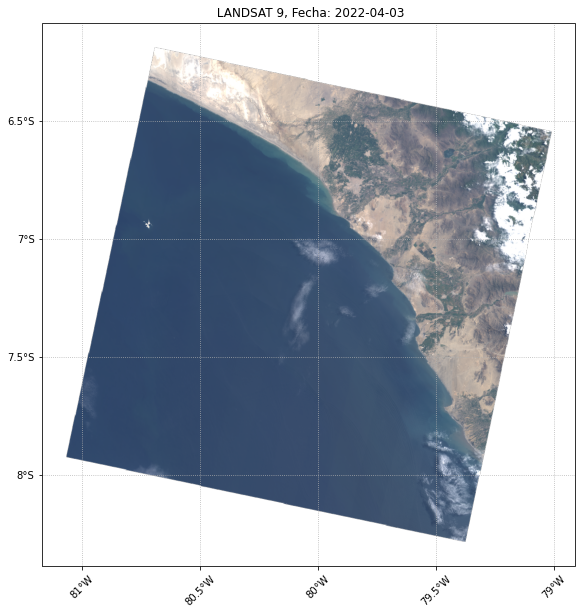

In [ ]:
img = ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403')
img_date = img.date().format('YYYY-MM-dd').getInfo()

vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

fig = plt.figure(figsize=(10, 10))

# use cartoee to get a map
ax = cartoee.get_map(img, vis_params=vis)

# pad the view for some visual appeal (pad de padding)
cartoee.pad_view(ax)

ax.set_title(f' LANDSAT 9, Fecha: {img_date}')

# add the gridlines and specify that the xtick labels be rotated 45 degrees
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=45, linestyle=":")

show()

###### Prueba con bucle for para 5 imágenes Landsat 

In [ ]:
ids = ['LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211212',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129',
       'LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220310',
       'LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403']

for id in ids:

  img = ee.Image(id)
  img_date = img.date().format('YYYY-MM-dd').getInfo()

  # define the visualization parameters to view
  vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

  fig = plt.figure(figsize=(10, 7))

  # here is the bounding box of the map extent we want to use
  # formatted a [E,S,W,N]
  zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

  # plot the map over the region of interest
  ax = cartoee.get_map(img.clip(predios_bound), vis_params=vis, region=zoom_region)
  
  ax.set_title(f'Fecha: {img_date}')

  # add the gridlines and specify that the xtick labels be rotated 45 degrees
  cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

  cartoee.add_north_arrow(ax, text='N', xy=(0.95, 0.97), fontsize=20)
  show()

###### Imagen SRTM con barra de color al costado

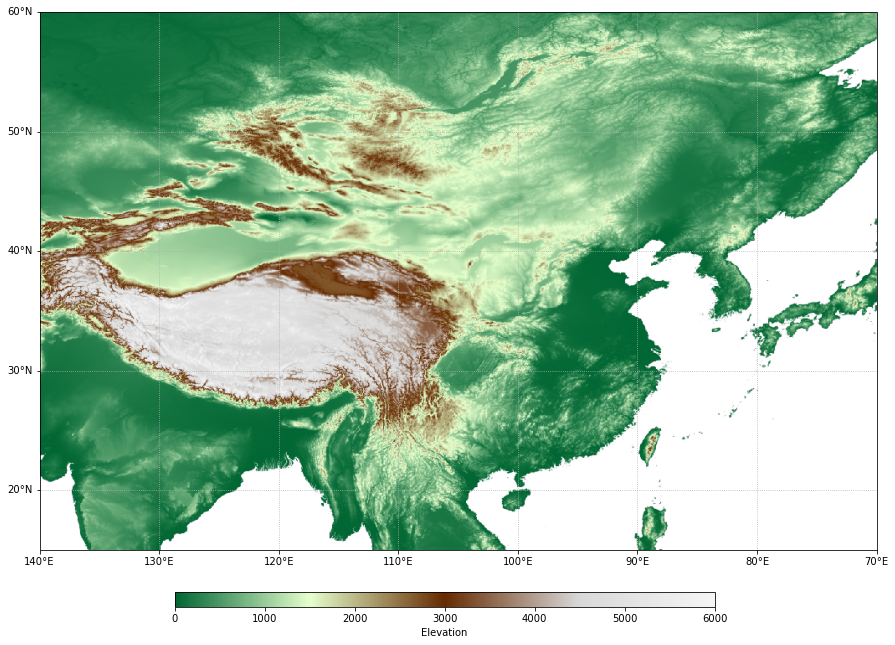

In [ ]:
# get an image
srtm = ee.Image("CGIAR/SRTM90_V4")

palette = geemap.colormaps.palettes.dem

region = [70, 15, 140, 60]  # define bounding box to request data
# vis = {'min': 0, 'max': 5000}  # define visualization parameters for image
vis = {'palette': palette, 'min': 0.0, 'max': 6000.0, 'opacity': 1.0}

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(srtm, region=region, vis_params=vis)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(
    ax,
    vis,
    loc="bottom",
    label="Elevation",
    orientation="horizontal",
    posOpts=[0.25, 0.05, 0.5, 0.02],
)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[10, 10], linestyle=":")

# add coastlines using the cartopy api
# ax.coastlines(color="red")

show()

###### Albedo a partir de una imagen Landsat 9 más su barra de color 

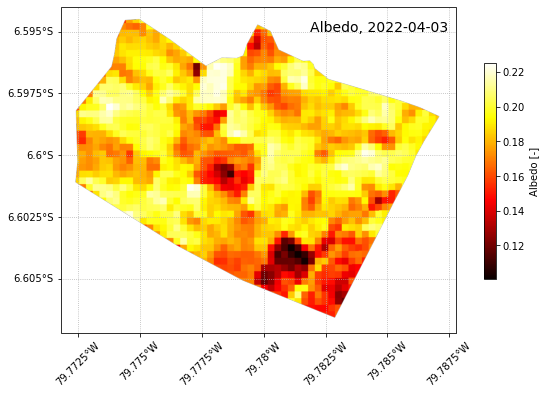

In [ ]:
# Previamente se necesita haber ejecutado las celdas de código sobre Radiación Neta 
vis_params_alb = {'min': albedo_stats[0]['Mínimo'], 
                  'max': albedo_stats[0]['Máximo'], 
                  # 'palette': cmp.get_palette(cmap_name='RdYlGn_r')}
                  'palette': cmp.get_palette(cmap_name='hot')}
                  # 'palette': cmp.palettes.ndvi} # pero esta paleta sí 
                  # 'palette': cmp.palettes.RdYlGn_r} # No reconoce la paleta 

img_ee = img_albedo.clip(predios_agricolas)#.visualize(**vis_params_alb) #ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403')

zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]

fig = plt.figure(figsize=(8,6))

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(img_ee, region=zoom_region, vis_params=vis_params_alb)
cb = cartoee.add_colorbar(ax, vis_params=vis_params_alb, loc='right', label="Albedo [-]")

# ax.set_title(label='Albedo, 2022-04-03')#, fontsize=15)

ax.text(-79.78185, -6.595, 'Albedo, 2022-04-03', fontsize=14)

cartoee.add_gridlines(ax, interval=0.0025, xtick_rotation=45, linestyle=":")

plt.show()

In [ ]:
# fig.savefig('albedo8x6_text.jpg')

##### Ploteo de imagenes en bucle (no se puede el subplots)

Revisar:
- https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html

In [ ]:
# zoom_region = [-79.787761, -6.607186, -79.771781, -6.593991]
img = ee.Image('LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220403').clip(predios_bound)
img_date = img.date().format('YYYY-MM-dd').getInfo()
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

In [49]:
ids

['LANDSAT/LC09/C02/T1/LC09_010065_20211212',
 'LANDSAT/LC09/C02/T1/LC09_010065_20220113',
 'LANDSAT/LC09/C02/T1/LC09_010065_20220129',
 'LANDSAT/LC08/C02/T1/LC08_010065_20220310',
 'LANDSAT/LC09/C02/T1/LC09_010065_20220403']

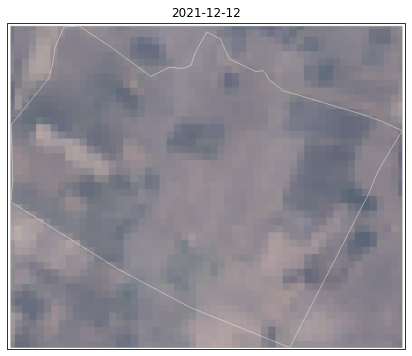

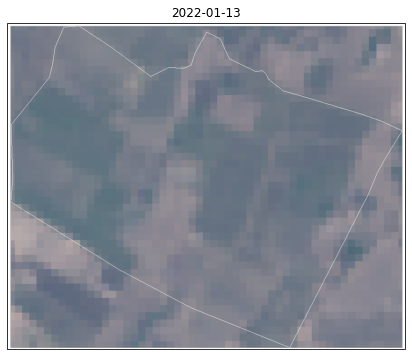

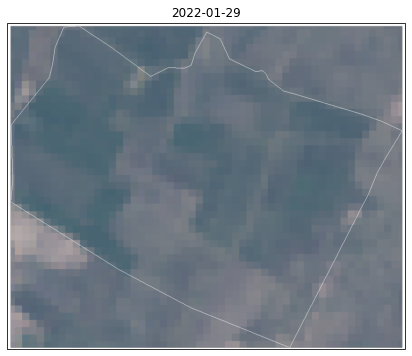

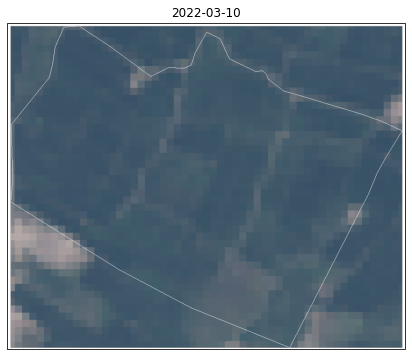

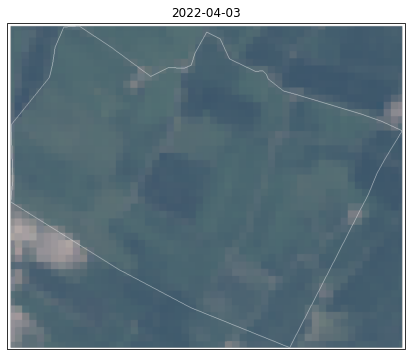

In [ ]:
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.3}

for id in ids:
  img_ee = ee.Image(id)
  img_toa = convert_RAW_to_TOA(img_ee).clip(predios_bound).blend(predios_vis)
  img_date = img_ee.date().format('YYYY-MM-dd').getInfo()

  fig = plt.figure(figsize=(8,6))
  ax = cartoee.get_map(img_toa, vis_params=vis)
  ax.set_title(img_date)
  
  ruta = r'C:/Users/usuario/Documents/00-notebooks-2022/'
  plt.savefig(f'{ruta+img_date}')
  plt.show()

###### Prueba: Animación

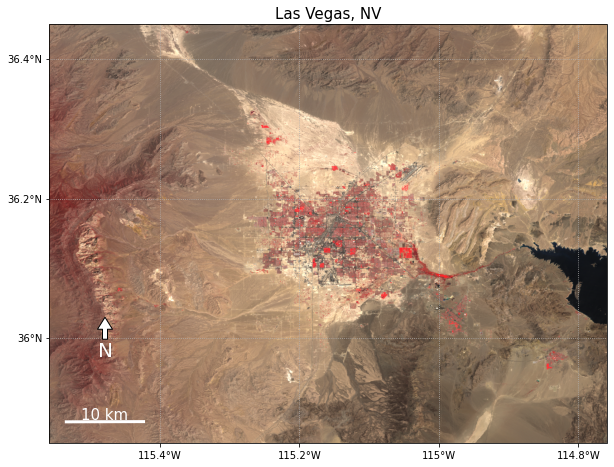

In [ ]:
# @markdown Prueba gif https://geemap.org/notebooks/52_cartoee_gif/#create-an-imagecollection
lon = -115.1585
lat = 36.1500
start_year = 1984
end_year = 2011

point = ee.Geometry.Point(lon, lat)
years = ee.List.sequence(start_year, end_year)

def get_best_image(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
        .filterBounds(point)
        .filterDate(start_date, end_date)
        .sort("CLOUD_COVER")
        .first()
    )
    return ee.Image(image)


collection = ee.ImageCollection(years.map(get_best_image))
vis_params = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 5000}
image = ee.Image(collection.first())

w = 0.4
h = 0.3

region = [lon + w, lat - h, lon - w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.08,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 15,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='Las Vegas, NV', fontsize=15)

show()

In [ ]:
#@markdown Prueba gif

icol = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1')
    .filterDate('2021-12','2022-05')
    .filterBounds(predios_bound)
    .filterMetadata('WRS_PATH', 'equals', 10)
    .filterMetadata('WRS_ROW', 'equals', 64)
    # .map(convert_RAW_to_TOA)
)

vis_rgb_raw = {'min': 0.0, 'max': 30000, 'bands': ['B4', 'B3', 'B2']}

# icol.aggregate_array('system:id').getInfo()

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}

cartoee.get_image_collection_gif(
    ee_ic=icol,
    out_dir=r'C:\Users\usuario\Documents\00-notebooks-2022',
    out_gif="animation.gif",
    vis_params=vis_rgb_raw,
    region=[-79.787761, -6.607186, -79.771781, -6.593991],
    fps=5,
    mp4=True,
    grid_interval=(0.0025, 0.0025),
    plot_title="Area de estudio, Ferreñafe",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

GIF saved to C:\Users\usuario\Documents\00-notebooks-2022\animation.gif
MP4 saved to C:\Users\usuario\Documents\00-notebooks-2022\animation.mp4


##### Por probar

Agregar un `ee.FeatureCollection`:
- [Add ee.Feature or ee.FeatureCollection using cartoee #212](https://github.com/giswqs/geemap/discussions/212)
- [Add multiple layers using cartoee.add_layer() together with eemont? #781](https://github.com/giswqs/geemap/issues/781)
- Respuesta: https://geemap.org/notebooks/57_cartoee_blend/

Agregar una barra de colores con cartoee

Probar: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/colorbar_placement.html#sphx-glr-gallery-subplots-axes-and-figures-colorbar-placement-py

<img src='https://matplotlib.org/stable/_images/sphx_glr_colorbar_placement_003.png' width=50%>

In [ ]:
import geemap.colormaps as cmp

In [ ]:
cmp.plot_colormaps()

In [ ]:
# image = (
#     ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
#     .filter(ee.Filter.date('2018-04-01', '2018-05-01'))
#     .select("NDVI")
#     .first()
# )

# vis_params = {
#     'min': 0.0,
#     'max': 1.0,
#     'palette': cmp.get_palette(cmap_name='RdYlGn_r'),
# }

# # FeatureCollection
# countries = ee.FeatureCollection('users/giswqs/public/countries')
# style = {"color": "00000088", "width": 1, "fillColor": "00000000"}

# # Blend
# ndvi = image.visualize(**vis_params)
# blend = ndvi.blend(countries.style(**style))

# # specify region to focus on
# bbox = [180, -88, -180, 88]
# fig = plt.figure(figsize=(15, 10))

# # plot the result with cartoee using a PlateCarre projection (default)
# ax = cartoee.get_map(blend, region=bbox)
# cb = cartoee.add_colorbar(ax, vis_params=vis_params, loc='right')

# ax.set_title(label='MODIS NDVI', fontsize=15)

# # ax.coastlines()
# plt.show()